# **Proyecto Final de Data Science, Coderhouse**

## **Prediciendo el valor de automóviles usados**

## Carga de librerías

In [1]:
import time
import datetime  # Importar datetime para manipulación de fechas y horas
import joblib  # Para utilizar joblib en sys.modules
import re  # Importar re para operaciones de expresiones regulares
import sys  # Para utilizar sys.modules
import numpy as np  # Importar NumPy para operaciones numéricas
import pandas as pd  # Importar Pandas para manipulación de datos
import matplotlib.pyplot as plt  # Importar Matplotlib para visualización de datos
import matplotlib as mpl  # Importar Matplotlib como mpl
import seaborn as sns  # Importar Seaborn para visualización estadística

from mlxtend.feature_selection import SequentialFeatureSelector as SFS  # Importar SequentialFeatureSelector de mlxtend para selección de características
from sklearn.model_selection import train_test_split  # Importar train_test_split para dividir datos en conjuntos de entrenamiento y prueba
from sklearn.linear_model import LinearRegression  # Importar LinearRegression para modelado de regresión lineal
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Importar StandardScaler y LabelEncoder para preprocesamiento de datos
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, mean_squared_log_error, r2_score  # Importar métricas de evaluación de modelos
from sklearn.linear_model import Lasso, Ridge  # Importar Lasso y Ridge para modelado de regresión con regularización
from sklearn.ensemble import RandomForestRegressor  # Importar RandomForestRegressor para modelado de regresión con random forest
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

pd.options.mode.chained_assignment = None  # Desactiva la advertencia SettingWithCopyWarning
np.seterr(divide='ignore', over='warn', under='ignore', invalid='ignore')
import warnings
# Configurar la gestión de advertencias
warnings.filterwarnings('ignore', category=RuntimeWarning, module='numpy')

## Carga de Dataset

Cargaremos el Dataset "New York Cars ~ Big Data (2023)" descargado desde la plataforma Kaggle (https://www.kaggle.com/datasets/ahmettalhabektas/new-york-cars-big-data-2023/), este es un archivo csv bastante grande que hemos subido en Github para cargarlo aquí a través de la librería "pandas".

In [2]:
# Primero levantamos nuestro dataset desde github
url = "https://raw.githubusercontent.com/JnAlvarez/CoderhouseProyectoFinal/main/New_York_cars.csv"
df = pd.read_csv(url)

# **Contexto Comercial**

## **Predicción de Precios de Autos Usados**

#### **Descripción del Problema:**

En la industria automotriz, determinar el precio justo de un automóvil usado es crucial tanto para los vendedores como para los compradores. Los vendedores desean establecer precios competitivos que atraigan a los compradores potenciales y maximicen sus ganancias, mientras que los compradores buscan obtener un valor justo por el vehículo que están adquiriendo. Sin embargo, la determinación del precio ideal de un automóvil usado puede ser un desafío debido a la amplia variedad de características y factores que influyen en su valor.

#### **Solución Propuesta:**

Para abordar este desafío, se desarrollará un modelo de machine learning que utiliza datos históricos de autos usados para predecir sus precios en función de diversas características. Nuestro modelo analizará características como el año de fabricación, el kilometraje, las características adicionales (por ejemplo, sistemas de entretenimiento, asientos con calefacción), el color, la marca y el tipo de combustible, entre otros, para estimar el precio de un automóvil usado.

#### **Beneficios para la Industria:**

**Precios Justos y Competitivos:** Nuestro modelo ayudará a establecer precios justos y competitivos para los automóviles usados, lo que beneficia tanto a los vendedores como a los compradores.

**Optimización de Inventario:** Los concesionarios y vendedores pueden utilizar las predicciones de precios para gestionar de manera más efectiva su inventario, ajustando los precios según la demanda del mercado y maximizando así sus ganancias.

**Mejora de la Experiencia del Cliente:** Los compradores pueden confiar en que están obteniendo un precio justo por el automóvil que están adquiriendo, lo que mejora su satisfacción y confianza en el proceso de compra.

## **Supuestos**

Antes de comenzar a desarrollar el proyecto, dejaremos estipulados algunos supuestos que nos ayudarán a dirigir nuestro estudio:

- La variable más fuertemente relacionada al precio es la marca del automóvil.
- La edad del auto tiene una relación inversamente proporcional con el precio.
- El rendimiento y la distancia recorrida está en el top 5 de variables más relacionadas con el precio.
- Los autos con combustibles alternativos/eléctricos/híbridos tienen un valor más alto.
- La existencia de tracción en las 4 ruedas (4x4 o 4Wd) aumenta el valor del vehículo.

## **Primera visualización**

Para iniciar vamos a explorar nuestro dataset desde varios puntos, para hacernos una idea general del mismo.

In [3]:
# Exploramos someramente nuestro dataset para hacernos una idea de los datos aquí contenidos.
print("------------------------ SHAPE ------------------------")
print(df.shape)
print("------------------------ DESCRIBE ---------------------")
print(df.describe())
print("------------------------ INFO -------------------------")
print(df.info())
print("------------------------ NULL -------------------------")
print(df.isnull().sum())

------------------------ SHAPE ------------------------
(175490, 24)
------------------------ DESCRIBE ---------------------
              money        Mileage           Year
count  1.754900e+05  175443.000000  175490.000000
mean   3.435422e+04   51195.466203    2018.551900
std    2.350952e+04   43350.071628       3.136994
min    1.895000e+03       0.000000    2012.000000
25%    1.999100e+04   15170.500000    2016.000000
50%    2.899000e+04   44328.000000    2019.000000
75%    4.199000e+04   78484.500000    2021.000000
max    2.200000e+06  763474.000000    2023.000000
------------------------ INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175490 entries, 0 to 175489
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   new&used             175490 non-null  object 
 1   name                 175490 non-null  object 
 2   money                175490 non-null  int64  
 3 

Observamos que tenemos un dataset bastante robusto, iniciando con más de 175 filas de datos distribuídas en 24 columnas. Podemos ver que las columnas contienen importante información sobre las características de los automóviles, y la mayoría de dichas columnas poseen datos faltantes o nulos.

In [4]:
print("------------------------ HEAD -------------------------")
print(df.head())

------------------------ HEAD -------------------------
  new&used                                  name  money  \
0      New               2023 Acura Integra Base  33095   
1      New                 2023 Acura Mdx A-Spec  61745   
2      New  2023 Acura Integra A-Spec Technology  38095   
3      New                 2023 Acura Tlx A-Spec  47995   
4      New                 2023 Acura Tlx A-Spec  47995   

             Exterior color Interior color Drivetrain     MPG Fuel type  \
0   Liquid Carbon Metallic          Ebony         Fwd   30–37  Gasoline   
1     Majestic Black Pearl          Ebony         Awd   19–25  Gasoline   
2     Majestic Black Pearl          Ebony         Fwd   26–36  Gasoline   
3     Majestic Black Pearl          Ebony         Fwd   22–30  Gasoline   
4     Platinum White Pearl            Red         Fwd   22–30  Gasoline   

         Transmission                      Engine  ...  \
0       Automatic Cvt  1.5L I4 16V Gdi Dohc Turbo  ...   
1  10-Speed Automatic 

Este "Head" nos permite observar el contenido de cada columna y el formato en que se encuentra, inmediatamente salta a la vista que algunas columnas como: "Safety" y "Seating" contienen información en un formato difícil de interpretar para los modelos, por lo cual debemos recordar solucionarlo más adelante.

## **Estructurando el dataset (Feature Engineering Parte 1)**

Este proyecto solo considerará el precio de los automóviles usados, por lo tanto, vamos a visualizar la cantidad de entradas de automóviles nuevos y las eliminaremos.

In [5]:
df['new&used'].value_counts()

new&used
Used                       135972
New                         29280
Mercedes-Benz Certified       778
Infiniti Certified            705
Porsche Certified             659
Toyota Certified              629
Volvo Certified               617
Honda Certified               615
Cadillac Certified            608
Bmw Certified                 580
Nissan Certified              501
Buick Certified               498
Volkswagen Certified          496
Subaru Certified              445
Jeep Certified                427
Acura Certified               416
Gmc Certified                 375
Kia Certified                 358
Ford Certified                354
Dodge Certified               323
Chevrolet Certified           316
Chrysler Certified            298
Ram Certified                 236
Mitsubishi Certified            4
Name: count, dtype: int64

In [6]:
df = df[df['new&used'] != 'New']
df['new&used'].value_counts()

new&used
Used                       135972
Mercedes-Benz Certified       778
Infiniti Certified            705
Porsche Certified             659
Toyota Certified              629
Volvo Certified               617
Honda Certified               615
Cadillac Certified            608
Bmw Certified                 580
Nissan Certified              501
Buick Certified               498
Volkswagen Certified          496
Subaru Certified              445
Jeep Certified                427
Acura Certified               416
Gmc Certified                 375
Kia Certified                 358
Ford Certified                354
Dodge Certified               323
Chevrolet Certified           316
Chrysler Certified            298
Ram Certified                 236
Mitsubishi Certified            4
Name: count, dtype: int64

Con esto hemos dejado solo los datos de los automóviles usados en nuestro dataset.

Con el head que hemos hecho pudimos observar que la columna "currency" parece tener información sobre la moneda en la que se encuentra el precio del automóvil, exploraremos dicha columna para entender como se encuentra distribuída.

In [7]:
df['currency'].value_counts()

currency
$    146210
Name: count, dtype: int64

Como podemos observar, todos los datos contenidos se encuentran en la misma divisa, lo que hace irrelevante esta columna, por lo que la eliminamos.

In [8]:
df = df.drop('currency', axis=1)
print("------------------------ INFO -------------------------")
print(df.info())

------------------------ INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 146210 entries, 60 to 175489
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   new&used             146210 non-null  object 
 1   name                 146210 non-null  object 
 2   money                146210 non-null  int64  
 3   Exterior color       144492 non-null  object 
 4   Interior color       133643 non-null  object 
 5   Drivetrain           145727 non-null  object 
 6   MPG                  134117 non-null  object 
 7   Fuel type            144935 non-null  object 
 8   Transmission         145838 non-null  object 
 9   Engine               145923 non-null  object 
 10  Mileage              146163 non-null  float64
 11  Convenience          118629 non-null  object 
 12  Entertainment        139875 non-null  object 
 13  Exterior             133055 non-null  object 
 14  Safety          

Podemos ver que la columna Clean title tiene muy pocos valores relativo a las demás columnas, por lo que revisaremos los null del mismo.

In [9]:
print("-------------- NULL (%) ---------------")
df.isnull().sum()/df.shape[0] * 100

-------------- NULL (%) ---------------


new&used                0.000000
name                    0.000000
money                   0.000000
Exterior color          1.175022
Interior color          8.595171
Drivetrain              0.330347
MPG                     8.270980
Fuel type               0.872033
Transmission            0.254429
Engine                  0.196293
Mileage                 0.032146
Convenience            18.863963
Entertainment           4.332809
Exterior                8.997333
Safety                  0.218863
Seating                32.404760
Accidents or damage    15.931879
Clean title            87.586348
1-owner vehicle        16.085767
Personal use only      15.932563
brand                   0.000000
Year                    0.000000
Model                   0.000000
dtype: float64

In [10]:
df['Clean title'].value_counts()

Clean title
Yes    17856
No       294
Name: count, dtype: int64

Según el dataset, esta columna contiene información sobre el estado legal del vehículo, al no poseer información relevante para nuestro estudio, además de poseer casi un 88% de nan, eliminaremos esta columna.

In [11]:
df = df.drop('Clean title', axis=1)
print("------------------------ INFO -------------------------")
print(df.info())

------------------------ INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 146210 entries, 60 to 175489
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   new&used             146210 non-null  object 
 1   name                 146210 non-null  object 
 2   money                146210 non-null  int64  
 3   Exterior color       144492 non-null  object 
 4   Interior color       133643 non-null  object 
 5   Drivetrain           145727 non-null  object 
 6   MPG                  134117 non-null  object 
 7   Fuel type            144935 non-null  object 
 8   Transmission         145838 non-null  object 
 9   Engine               145923 non-null  object 
 10  Mileage              146163 non-null  float64
 11  Convenience          118629 non-null  object 
 12  Entertainment        139875 non-null  object 
 13  Exterior             133055 non-null  object 
 14  Safety          

Ahora realizaremos algunos cambios, principalmente por comodidad de trabajo, como poner en mayúsculas todos los títulos de columnas, renombrar la columna "money" por "Price" ya que esta es la columna que contiene el valor de cada vehículo, etc.

In [12]:
# Crear un diccionario para mapear los nombres de columnas antiguas a los nuevos nombres
nuevos_nombres = {
    'new&used': 'Usado (tipo)',
    'money': 'Price',
    'name': 'Name',
    'brand': 'Brand'
}

# Cambiar los nombres de las columnas utilizando el diccionario y el método rename
df = df.rename(columns=nuevos_nombres)

# Imprimir el DataFrame con los nuevos nombres de columnas
print("------------------------ INFO -------------------------")
print(df.info())

------------------------ INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 146210 entries, 60 to 175489
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Usado (tipo)         146210 non-null  object 
 1   Name                 146210 non-null  object 
 2   Price                146210 non-null  int64  
 3   Exterior color       144492 non-null  object 
 4   Interior color       133643 non-null  object 
 5   Drivetrain           145727 non-null  object 
 6   MPG                  134117 non-null  object 
 7   Fuel type            144935 non-null  object 
 8   Transmission         145838 non-null  object 
 9   Engine               145923 non-null  object 
 10  Mileage              146163 non-null  float64
 11  Convenience          118629 non-null  object 
 12  Entertainment        139875 non-null  object 
 13  Exterior             133055 non-null  object 
 14  Safety          

Por simple comodidad reordenaremos las columnas.

In [13]:
nuevo_orden_columnas = ['Name', 'Year', 'Brand', 'Model', 'Usado (tipo)', 'Price', 'Exterior color', 'Interior color',
                        'Drivetrain', 'MPG', 'Fuel type', 'Transmission', 'Engine', 'Mileage', 'Convenience', 'Entertainment',
                        'Exterior', 'Safety', 'Seating', 'Accidents or damage', '1-owner vehicle', 'Personal use only']

# Reorganizar las columnas en el DataFrame
df = df[nuevo_orden_columnas]

print("------------------------ INFO -------------------------")
print(df.info())

------------------------ INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 146210 entries, 60 to 175489
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Name                 146210 non-null  object 
 1   Year                 146210 non-null  int64  
 2   Brand                146210 non-null  object 
 3   Model                146210 non-null  object 
 4   Usado (tipo)         146210 non-null  object 
 5   Price                146210 non-null  int64  
 6   Exterior color       144492 non-null  object 
 7   Interior color       133643 non-null  object 
 8   Drivetrain           145727 non-null  object 
 9   MPG                  134117 non-null  object 
 10  Fuel type            144935 non-null  object 
 11  Transmission         145838 non-null  object 
 12  Engine               145923 non-null  object 
 13  Mileage              146163 non-null  float64
 14  Convenience     

### **Creación de columnas Dummy a partir de Columnas con información categórica**

Como pudimos observar anteriormente existen varias columnas que contienen datos categóricos agrupados en una sola celda, esta información será de poca utilidad si la mantenemos de esta manera, por lo que iteraremos por cada una de ellas buscando las distintas características que contiene cada celda, creando una columna para cada característica que contendrá un 0 si la entrada posee dicha característica y un 1 si es que la posee.

In [14]:
print("------------------------ HEAD -------------------------")
print(df['Convenience'].head())
print("------------------------ HEAD -------------------------")
print(df['Entertainment'].head())
print("------------------------ HEAD -------------------------")
print(df['Seating'].head())
print("------------------------ HEAD -------------------------")
print(df['Safety'].head())
print("------------------------ HEAD -------------------------")
print(df['Exterior'].head())

------------------------ HEAD -------------------------
60                Adaptive Cruise ControlKeyless Start  
107      Adaptive Cruise ControlHeated SeatsNavigatio...
112      Adaptive Cruise ControlHeated SeatsNavigatio...
118      Adaptive Cruise ControlHeated SeatsHeated St...
140      Adaptive Cruise ControlHeated SeatsKeyless S...
Name: Convenience, dtype: object
------------------------ HEAD -------------------------
60         Apple CarPlay/Android AutoBluetoothUSB Port  
107      Apple CarPlay/Android AutoBluetoothPremium S...
112      Apple CarPlay/Android AutoBluetoothHomeLinkP...
118      Apple CarPlay/Android AutoBluetoothPremium S...
140      Apple CarPlay/Android AutoBluetoothPremium S...
Name: Entertainment, dtype: object
------------------------ HEAD -------------------------
60                                   Leather Seats  
107                       Leather SeatsMemory Seat  
112      Leather SeatsMemory SeatThird Row Seating  
118      Leather SeatsMemory SeatTh

In [15]:
# Crear columnas Dummy a partir de los datos contenidos en la columna "Convenience"
# Nombres a buscar
nombres_a_buscar = ['Adaptive Cruise Control', 'Heated Seats', 'Cooled Seats', 'Keyless Start', 
                    'Navigation System', 'Power Liftgate', 'Remote Start', 'Heated Steering Wheel']

# Crear una máscara booleana para cada columna en base a la columna 'Convenience'
mascaras = df['Convenience'].str.contains('|'.join(nombres_a_buscar), na=False)

# Asignar los valores a las columnas correspondientes
df.loc[mascaras, nombres_a_buscar] = 1
df[nombres_a_buscar] = df[nombres_a_buscar].fillna(0)

# Eliminar la columna 'Convenience'
df = df.drop(columns=['Convenience'])

In [16]:
# Crear columnas Dummy a partir de los datos contenidos en la columna "Entertainment"
# Nombres a buscar
nombres_a_buscar = ['Apple CarPlay/Android Auto', 'USB Port', 'Premium Sound System', 'Bluetooth', 'HomeLink', 'Rear Seat Entertainment']

# Crear una máscara booleana para cada columna en base a la columna 'Entertainment'
mascaras = df['Entertainment'].str.contains('|'.join(nombres_a_buscar), na=False)

# Asignar los valores a las columnas correspondientes
df.loc[mascaras, nombres_a_buscar] = 1
df[nombres_a_buscar] = df[nombres_a_buscar].fillna(0)

# Eliminar la columna 'Entertainment'
df = df.drop(columns=['Entertainment'])

In [17]:
# Crear columnas Dummy a partir de los datos contenidos en la columna "Seating"
# Nombres a buscar
nombres_a_buscar = ['Memory Seat', 'Third Row Seating', 'Leather Seats']

# Crear una máscara booleana para cada columna en base a la columna 'Seating'
mascaras = df['Seating'].str.contains('|'.join(nombres_a_buscar), na=False)

# Asignar los valores a las columnas correspondientes
df.loc[mascaras, nombres_a_buscar] = 1
df[nombres_a_buscar] = df[nombres_a_buscar].fillna(0)

# Eliminar la columna 'Seating'
df = df.drop(columns=['Seating'])

In [18]:
# Crear columnas Dummy a partir de los datos contenidos en la columna "Safety"
# Nombres a buscar
nombres_a_buscar = ['Blind Spot Monitor', 'Rear Cross Traffic Alert', 'Backup Camera', 'Lane Departure Warning']

# Crear una máscara booleana para cada columna en base a la columna 'Safety'
mascaras = df['Safety'].str.contains('|'.join(nombres_a_buscar), na=False)

# Asignar los valores a las columnas correspondientes
df.loc[mascaras, nombres_a_buscar] = 1
df[nombres_a_buscar] = df[nombres_a_buscar].fillna(0)

# Eliminar la columna 'Safety'
df = df.drop(columns=['Safety'])

In [19]:
# Crear columnas Dummy a partir de los datos contenidos en la columna "Exterior"
# Nombres a buscar
nombres_a_buscar = ['Alloy Wheels', 'Sunroof/Moonroof', 'Tow Hitch', 'Tow Hooks']

# Crear una máscara booleana para cada columna en base a la columna 'Exterior'
mascaras = df['Exterior'].str.contains('|'.join(nombres_a_buscar), na=False)

# Asignar los valores a las columnas correspondientes
df.loc[mascaras, nombres_a_buscar] = 1
df[nombres_a_buscar] = df[nombres_a_buscar].fillna(0)

# Eliminar la columna 'Exterior'
df = df.drop(columns=['Exterior'])

In [20]:
print("------------------------ INFO -------------------------")
print(df.info())

------------------------ INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 146210 entries, 60 to 175489
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Name                        146210 non-null  object 
 1   Year                        146210 non-null  int64  
 2   Brand                       146210 non-null  object 
 3   Model                       146210 non-null  object 
 4   Usado (tipo)                146210 non-null  object 
 5   Price                       146210 non-null  int64  
 6   Exterior color              144492 non-null  object 
 7   Interior color              133643 non-null  object 
 8   Drivetrain                  145727 non-null  object 
 9   MPG                         134117 non-null  object 
 10  Fuel type                   144935 non-null  object 
 11  Transmission                145838 non-null  object 
 12  Engine              

In [21]:
print("------------------------ HEAD -------------------------")
print(df.head()["Third Row Seating"])
print("---------------------- DESCRIBE -----------------------")
print(df["Third Row Seating"].describe())

------------------------ HEAD -------------------------
60     1.0
107    1.0
112    1.0
118    1.0
140    1.0
Name: Third Row Seating, dtype: float64
---------------------- DESCRIBE -----------------------
count    146210.000000
mean          0.675952
std           0.468019
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Third Row Seating, dtype: float64


Al inspeccionar una columna de ejemplo como lo es "Third Row Seating" podemos observar que la extracción de información y la creación de columnas con valores binarios se realizó correctamente.

## **Tratamiento de NaN**

Primero observaremos el porcentaje de NaN en cada columna.

In [22]:
print("-------------- NULL (%) ---------------")
df.isnull().sum()/df.shape[0] * 100

-------------- NULL (%) ---------------


Name                           0.000000
Year                           0.000000
Brand                          0.000000
Model                          0.000000
Usado (tipo)                   0.000000
Price                          0.000000
Exterior color                 1.175022
Interior color                 8.595171
Drivetrain                     0.330347
MPG                            8.270980
Fuel type                      0.872033
Transmission                   0.254429
Engine                         0.196293
Mileage                        0.032146
Accidents or damage           15.931879
1-owner vehicle               16.085767
Personal use only             15.932563
Adaptive Cruise Control        0.000000
Heated Seats                   0.000000
Cooled Seats                   0.000000
Keyless Start                  0.000000
Navigation System              0.000000
Power Liftgate                 0.000000
Remote Start                   0.000000
Heated Steering Wheel          0.000000


Podemos observar varias columnas con diversos porcentajes de valores NaN, primero eliminaremos las filas que contengan NaN en todas aquellas columnas con un porcentaje menor al 1%, ya que hacerlo no tendrá un impacto mayor en nuestro análisis, sobre todo teniendo en cuenta el tamaño de nuestro dataset.

In [23]:
df.dropna(subset = ["Drivetrain","Fuel type","Transmission","Engine","Mileage"], inplace = True)

print("-------------- NULL (%) ---------------")
df.isnull().sum()/df.shape[0] * 100

-------------- NULL (%) ---------------


Name                           0.000000
Year                           0.000000
Brand                          0.000000
Model                          0.000000
Usado (tipo)                   0.000000
Price                          0.000000
Exterior color                 1.159350
Interior color                 8.478570
Drivetrain                     0.000000
MPG                            7.880531
Fuel type                      0.000000
Transmission                   0.000000
Engine                         0.000000
Mileage                        0.000000
Accidents or damage           15.806105
1-owner vehicle               15.954402
Personal use only             15.806798
Adaptive Cruise Control        0.000000
Heated Seats                   0.000000
Cooled Seats                   0.000000
Keyless Start                  0.000000
Navigation System              0.000000
Power Liftgate                 0.000000
Remote Start                   0.000000
Heated Steering Wheel          0.000000


Observamos un 1.1% de valores NaN en la columna "Exterior color" y un 8.6% en la columna "Interior color", como estas columnas nos entregan información que puede ser de utilidad y los valores faltantes no llega al 10%, siendo esta una columna con datos categóricos, reemplazaremos los datos faltantes (NaN) por la moda de cada columna.

In [24]:
df["Exterior color"] = df["Exterior color"].fillna(df["Exterior color"].mode()[0])
df["Interior color"] = df["Interior color"].fillna(df["Interior color"].mode()[0])

print("-------------- NULL (%) ---------------")
df.isnull().sum()/df.shape[0] * 100

-------------- NULL (%) ---------------


Name                           0.000000
Year                           0.000000
Brand                          0.000000
Model                          0.000000
Usado (tipo)                   0.000000
Price                          0.000000
Exterior color                 0.000000
Interior color                 0.000000
Drivetrain                     0.000000
MPG                            7.880531
Fuel type                      0.000000
Transmission                   0.000000
Engine                         0.000000
Mileage                        0.000000
Accidents or damage           15.806105
1-owner vehicle               15.954402
Personal use only             15.806798
Adaptive Cruise Control        0.000000
Heated Seats                   0.000000
Cooled Seats                   0.000000
Keyless Start                  0.000000
Navigation System              0.000000
Power Liftgate                 0.000000
Remote Start                   0.000000
Heated Steering Wheel          0.000000


In [25]:
df["Exterior color"] = df["Exterior color"].fillna(df["Exterior color"].mode()[0])
df["Interior color"] = df["Interior color"].fillna(df["Interior color"].mode()[0])

In [26]:
print("------------------------ INFO -------------------------")
print(df.info())

------------------------ INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 144305 entries, 60 to 175489
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Name                        144305 non-null  object 
 1   Year                        144305 non-null  int64  
 2   Brand                       144305 non-null  object 
 3   Model                       144305 non-null  object 
 4   Usado (tipo)                144305 non-null  object 
 5   Price                       144305 non-null  int64  
 6   Exterior color              144305 non-null  object 
 7   Interior color              144305 non-null  object 
 8   Drivetrain                  144305 non-null  object 
 9   MPG                         132933 non-null  object 
 10  Fuel type                   144305 non-null  object 
 11  Transmission                144305 non-null  object 
 12  Engine              

Ahora trataremos las columnas que aún tienen NaN, en este caso: "MPG", "Accidents or damage", "1-owner vehicle" y "Personal use only", como podemos observar todos ellos tienen datos tipo "object" lo que nos da a entender que contienen variables categóricas, al tener altos porcentajes de NaN y entregar información relevante para nuestro estudio, reemplazaremos los NaN con la moda de cada columna.

In [27]:
df["MPG"] = df["MPG"].fillna(df["MPG"].mode()[0])
df["Accidents or damage"] = df["Accidents or damage"].fillna(df["Accidents or damage"].mode()[0])
df["1-owner vehicle"] = df["1-owner vehicle"].fillna(df["1-owner vehicle"].mode()[0])
df["Personal use only"] = df["Personal use only"].fillna(df["Personal use only"].mode()[0])

print("-------------- NULL (%) ---------------")
df.isnull().sum()/df.shape[0] * 100

-------------- NULL (%) ---------------


Name                          0.0
Year                          0.0
Brand                         0.0
Model                         0.0
Usado (tipo)                  0.0
Price                         0.0
Exterior color                0.0
Interior color                0.0
Drivetrain                    0.0
MPG                           0.0
Fuel type                     0.0
Transmission                  0.0
Engine                        0.0
Mileage                       0.0
Accidents or damage           0.0
1-owner vehicle               0.0
Personal use only             0.0
Adaptive Cruise Control       0.0
Heated Seats                  0.0
Cooled Seats                  0.0
Keyless Start                 0.0
Navigation System             0.0
Power Liftgate                0.0
Remote Start                  0.0
Heated Steering Wheel         0.0
Apple CarPlay/Android Auto    0.0
USB Port                      0.0
Premium Sound System          0.0
Bluetooth                     0.0
HomeLink      

## Estructurando el dataset (Feature Engineering Parte 2)

Habiendo tratado los NaN seguiremos con la estructuración de nuestro dataset y la ingeniería de características. Ahora crearemos columnas Dummy para las columnas "Exterior color" e "Interior color", pero lo haremos agrupando los datos en grupos por color, asignando un 1 cuando dicho color se encuentre presente en la columna correspondiente y un cero en caso de no contenerlo. Si la columna de origen no contiene ninguna de los colores filtrados se pondrá un 1 en las columnas "Color_Other" o "IntColor_Other" según corresponda.

In [28]:
# Convertir todas las palabras a minúsculas para que no se diferencie entre mayúsculas y minúsculas
df['Exterior color'] = df['Exterior color'].str.lower()

# Crear las columnas específicas y asignar 0 a todas las filas
df['Color_Black'] = 0
df['Color_White'] = 0
df['Color_Gray'] = 0
df['Color_Red'] = 0
df['Color_Blue'] = 0
df['Color_Brown'] = 0
df['Color_Green'] = 0
df['Color_Gold'] = 0
df['Color_Orange'] = 0
df['Color_Yellow'] = 0
df['Color_Other'] = 0

# Asignar 1 a las columnas correspondientes
df.loc[df['Exterior color'].str.contains(r'black|graphite|ebony'), 'Color_Black'] = 1
df.loc[df['Exterior color'].str.contains(r'white|blizzard'), 'Color_White'] = 1
df.loc[df['Exterior color'].str.contains(r'gray|silver|gun|platinum|granite'), 'Color_Gray'] = 1
df.loc[df['Exterior color'].str.contains(r'red|maroon'), 'Color_Red'] = 1
df.loc[df['Exterior color'].str.contains(r'blue'), 'Color_Blue'] = 1
df.loc[df['Exterior color'].str.contains(r'brown'), 'Color_Brown'] = 1
df.loc[df['Exterior color'].str.contains(r'green'), 'Color_Green'] = 1
df.loc[df['Exterior color'].str.contains(r'gold'), 'Color_Gold'] = 1
df.loc[df['Exterior color'].str.contains(r'orange'), 'Color_Orange'] = 1
df.loc[df['Exterior color'].str.contains(r'yellow'), 'Color_Yellow'] = 1

# Si no coincide con ninguna categoría, se considera 'Other'
df.loc[(df['Color_Black'] + df['Color_White'] + df['Color_Gray'] + df['Color_Red'] +
        df['Color_Blue'] + df['Color_Brown'] + df['Color_Green'] +
        df['Color_Gold'] + df['Color_Orange'] + df['Color_Yellow']) == 0, 'Color_Other'] = 1

In [29]:
# Convertir todas las palabras a minúsculas para que no se diferencie entre mayúsculas y minúsculas
df['Interior color'] = df['Interior color'].str.lower()

# Crear las columnas específicas y asignar 0 a todas las filas
df['IntColor_Black'] = 0
df['IntColor_White'] = 0
df['IntColor_Gray'] = 0
df['IntColor_Brown'] = 0
df['IntColor_LightBrown'] = 0
df['IntColor_Red'] = 0
df['IntColor_Other'] = 0

# Asignar 1 a las columnas correspondientes
df.loc[df['Interior color'].str.contains(r'black|ebony|charcoal'), 'IntColor_Black'] = 1
df.loc[df['Interior color'].str.contains(r'white|ivory|snow|cream'), 'IntColor_White'] = 1
df.loc[df['Interior color'].str.contains(r'gray|silver|graphite|ash|stone|alloy|steel|rock|platinum|titanium'), 'IntColor_Gray'] = 1
df.loc[df['Interior color'].str.contains(r'brown|walnut|chestnut|nougat|cognac|espresso'), 'IntColor_Brown'] = 1
df.loc[df['Interior color'].str.contains(r'beige|tan|parchment|wheat|cappuccino|almond|sand|amber|camel'), 'IntColor_LightBrown'] = 1
df.loc[df['Interior color'].str.contains(r'red'), 'IntColor_Red'] = 1

# Si no coincide con ninguna categoría, se considera 'Other'
df.loc[(df['IntColor_Black'] + df['IntColor_White'] + df['IntColor_Gray'] + df['IntColor_Brown'] +
        df['IntColor_LightBrown'] + df['IntColor_Red']) == 0, 'IntColor_Other'] = 1

In [30]:
print("------------------------ INFO -------------------------")
print(df.info())

------------------------ INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 144305 entries, 60 to 175489
Data columns (total 60 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Name                        144305 non-null  object 
 1   Year                        144305 non-null  int64  
 2   Brand                       144305 non-null  object 
 3   Model                       144305 non-null  object 
 4   Usado (tipo)                144305 non-null  object 
 5   Price                       144305 non-null  int64  
 6   Exterior color              144305 non-null  object 
 7   Interior color              144305 non-null  object 
 8   Drivetrain                  144305 non-null  object 
 9   MPG                         144305 non-null  object 
 10  Fuel type                   144305 non-null  object 
 11  Transmission                144305 non-null  object 
 12  Engine              

Ahora analizaremos la columna Price, esta es nuestra variable objetivo así que queremos que esté en la mejor forma posible.

In [31]:
# Configurar Pandas para que no use notación científica
pd.set_option('display.float_format', '{:.2f}'.format)

print("------------------------ DESCRIBE -------------------------")
df["Price"].describe()

------------------------ DESCRIBE -------------------------


count    144305.00
mean      30248.87
std       20963.47
min        1895.00
25%       18650.00
50%       25995.00
75%       35990.00
max     2200000.00
Name: Price, dtype: float64

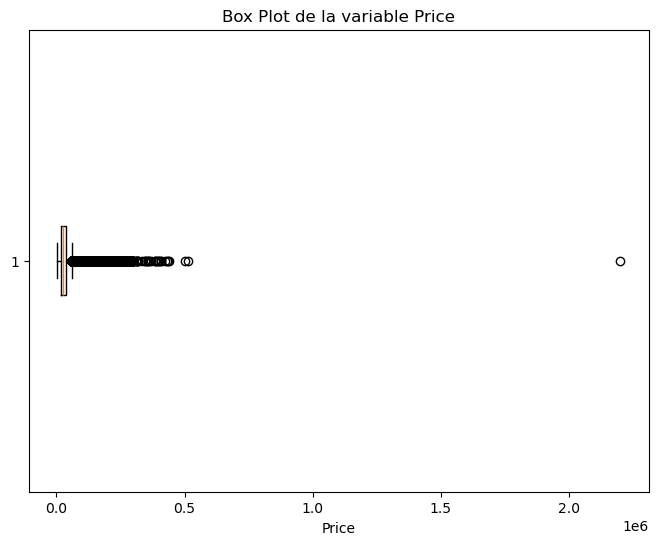

In [32]:
# Crear el box plot
plt.figure(figsize=(8, 6))
plt.boxplot(df['Price'], vert=False)  # vert=False para hacer el box plot horizontal
plt.xlabel('Price')
plt.title('Box Plot de la variable Price')
plt.show()

Podemos observar que el valor mínimo y máximo están muy separados, además el valor máximo se escapa demasiado del percentil 75. Por ello eliminaremos los outliers.

In [33]:
# Calcular el rango intercuartílico (IQR)
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los valores atípicos
df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

print("------------------------ SHAPE ------------------------")
print(df.shape)

------------------------ SHAPE ------------------------
(137367, 60)


In [34]:
print("------------------------ DESCRIBE -------------------------")
df["Price"].describe()

------------------------ DESCRIBE -------------------------


count   137367.00
mean     27105.63
std      11605.86
min       1895.00
25%      18000.00
50%      25223.00
75%      33998.00
max      62000.00
Name: Price, dtype: float64

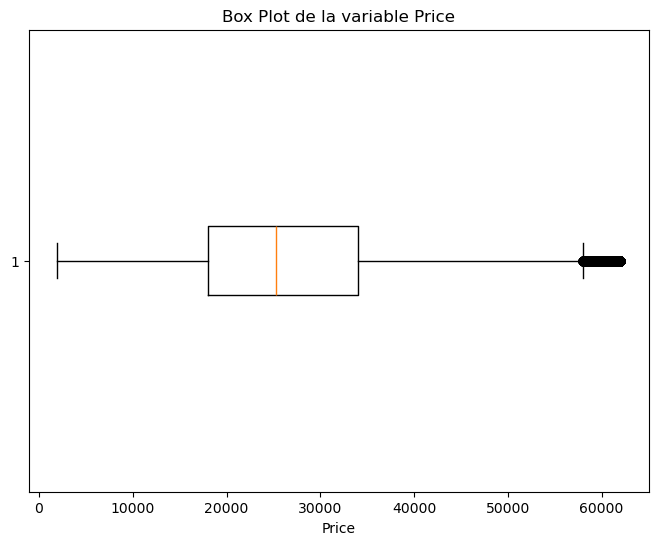

In [35]:
# Crear el box plot
plt.figure(figsize=(8, 6))
plt.boxplot(df['Price'], vert=False)  # vert=False para hacer el box plot horizontal
plt.xlabel('Price')
plt.title('Box Plot de la variable Price')
plt.show()

Podemos observar que ahora los valores se encuentran mucho más cerca los unos de los otros. Sabiendo que Price es nuestra variable objetivo, la graficaremos para ver su distribución.

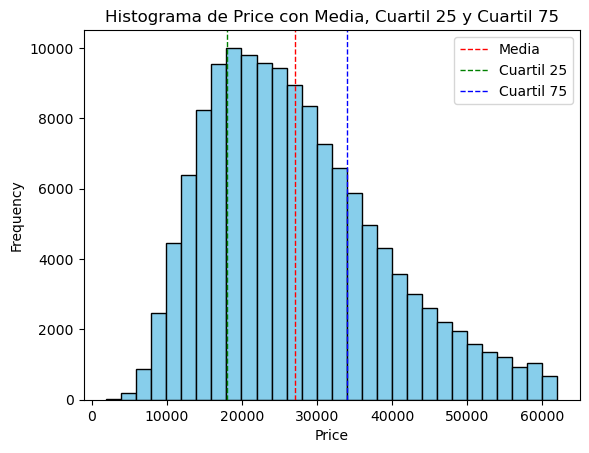

In [36]:
# Calcular la media, cuartil 25 y cuartil 75
mean_price = df['Price'].mean()
q25 = df['Price'].quantile(0.25)
q75 = df['Price'].quantile(0.75)

# Crear el histograma
plt.hist(df['Price'], bins=30, color='skyblue', edgecolor='black')

# Añadir líneas verticales para la media, cuartil 25 y cuartil 75
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(q25, color='green', linestyle='dashed', linewidth=1, label='Cuartil 25')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=1, label='Cuartil 75')

# Añadir leyenda y etiquetas
plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histograma de Price con Media, Cuartil 25 y Cuartil 75')

# Mostrar el histograma
plt.show()

Como podemos ver, la distribución de la variable objetivo presenta un sesgo a la derecha, por lo cual aplicaremos una transformación logarítmica y graficaremos nuevamente.

In [37]:
# Aplicar la transformación logarítmica a la columna "Price"
df['Price_log'] = np.log(df['Price'])

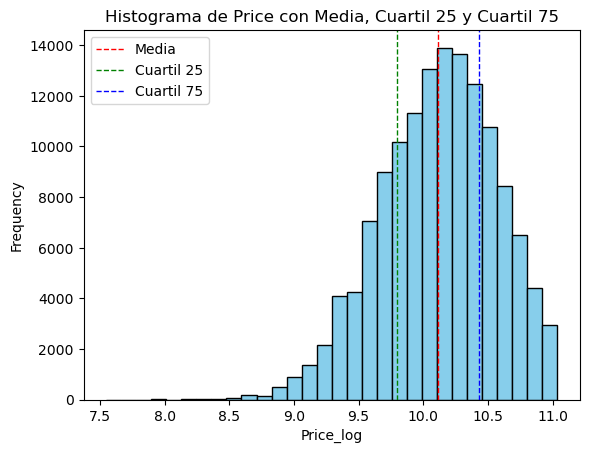

In [38]:
# Calcular la media, cuartil 25 y cuartil 75
mean_price = df['Price_log'].mean()
q25 = df['Price_log'].quantile(0.25)
q75 = df['Price_log'].quantile(0.75)

# Crear el histograma
plt.hist(df['Price_log'], bins=30, color='skyblue', edgecolor='black')

# Añadir líneas verticales para la media, cuartil 25 y cuartil 75
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(q25, color='green', linestyle='dashed', linewidth=1, label='Cuartil 25')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=1, label='Cuartil 75')

# Añadir leyenda y etiquetas
plt.legend()
plt.xlabel('Price_log')
plt.ylabel('Frequency')
plt.title('Histograma de Price con Media, Cuartil 25 y Cuartil 75')

# Mostrar el histograma
plt.show()

De esta manera, se puede apreciar una distribución más similar a una distribución "Normal", obteniendo una forma más simétrica de la variable.

Ahora trataremos la columna "MPG", como hemos visto esta posee strings con el rango de Millas por Galón de cada uno de los automóviles, esta es una información muy relevante para nuestro estudio, pero en el estado actual no nos es muy útil, es por ello que para cada rango calcularemos el promedio y lo reemplazaremos en la columna.

In [39]:
def promedio_rango(rango):
    if isinstance(rango, str):
        valores = [float(valor) if '.' in valor else int(valor) for valor in rango.replace('–', '-').split('-')]
        return sum(valores) / len(valores)
    else:
        return rango  # Si el valor no es una cadena, simplemente lo retornamos

# Aplicamos la función a la columna 'MPG' y creamos la nueva columna 'MpG'
df['MPG_mean'] = df['MPG'].apply(promedio_rango)

print("------------------------ MPG -------------------------")
print(df["MPG"].head())
print("--------------------- MPG_mean -----------------------")
print(df["MPG_mean"].head())

------------------------ MPG -------------------------
60      29–36
107     29–36
112     19–25
118     19–25
140     29–36
Name: MPG, dtype: object
--------------------- MPG_mean -----------------------
60    32.50
107   32.50
112   22.00
118   22.00
140   32.50
Name: MPG_mean, dtype: float64


Observamos que nuestra función se ha aplicado correctamente y ahora tenemos una columna "MPG_mean" que contiene el promedio del rango correspondiente en la columna "MPG" y ahora esta columna es del tipo float64. Revisaremos esta nueva columna buscando valores atípicos.

In [40]:
print("------------------------ DESCRIBE -------------------------")
df["MPG_mean"].describe()

------------------------ DESCRIBE -------------------------


count   137367.00
mean        24.54
std          5.65
min          0.00
25%         21.50
50%         23.50
75%         27.50
max        127.50
Name: MPG_mean, dtype: float64

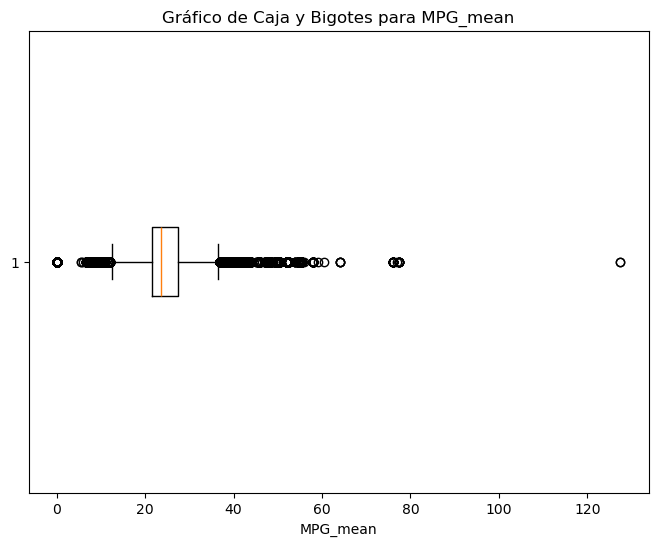

In [41]:
# Crear el gráfico de caja y bigotes
plt.figure(figsize=(8, 6))
plt.boxplot(df['MPG_mean'], vert=False)

# Añadir título y etiqueta al eje x
plt.title('Gráfico de Caja y Bigotes para MPG_mean')
plt.xlabel('MPG_mean')

# Mostrar el gráfico
plt.show()

"Describe" nos muestra valores mínimos de 0 y un máximo de 127, mientras los percentiles 25, 50 y 75 rondan todos el rango de 20-30, además el gráfico de caja y bigotes nos muestra gran cantidad de outliers. Calcularemos entonces los rangos intercuartílicos y eliminaremos los outliers.

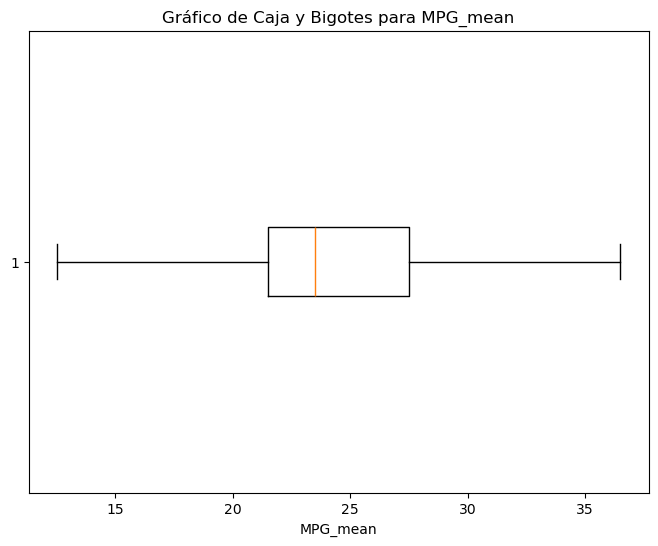

In [42]:
# Calcular el rango intercuartílico (IQR)
Q1 = df['MPG_mean'].quantile(0.25)
Q3 = df['MPG_mean'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los valores atípicos
df = df[(df['MPG_mean'] >= lower_bound) & (df['MPG_mean'] <= upper_bound)]

# Crear el gráfico de caja y bigotes
plt.figure(figsize=(8, 6))
plt.boxplot(df['MPG_mean'], vert=False)

# Añadir título y etiqueta al eje x
plt.title('Gráfico de Caja y Bigotes para MPG_mean')
plt.xlabel('MPG_mean')

# Mostrar el gráfico
plt.show()

In [43]:
print("------------------------ DESCRIBE -------------------------")
df["MPG_mean"].describe()

------------------------ DESCRIBE -------------------------


count   133426.00
mean        24.32
std          4.44
min         12.50
25%         21.50
50%         23.50
75%         27.50
max         36.50
Name: MPG_mean, dtype: float64

Observamos una variable mucho mejor distribuída y sin outliers.

Antes de continuar con el siguiente paso, visualizaremos rapidamente nuestra última variable numérica continua: "Mileage" para ver si es necesario algún tratamiento.

In [44]:
df["Mileage"].describe()

count   133426.00
mean     63020.92
std      39721.85
min          0.00
25%      32446.50
50%      57599.50
75%      87284.50
max     763474.00
Name: Mileage, dtype: float64

Vemos que tenemos un máximo 8 o 9 veces más grande que nuestro percentil 75, observaremos ahora esta variable gráficamente.

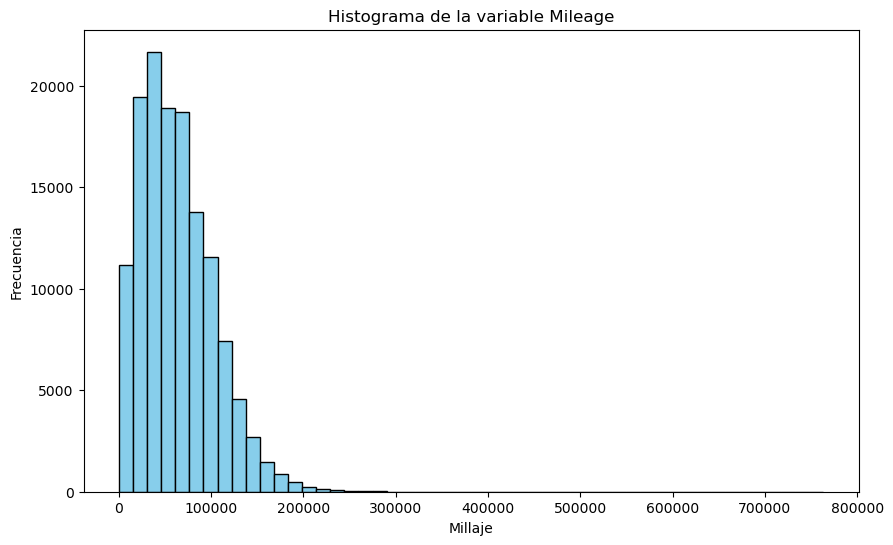

In [45]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(df['Mileage'], bins=50, color='skyblue', edgecolor='black')

# Ajustar las etiquetas y el título
plt.xlabel('Millaje')
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable Mileage')

# Mostrar el histograma
plt.show()

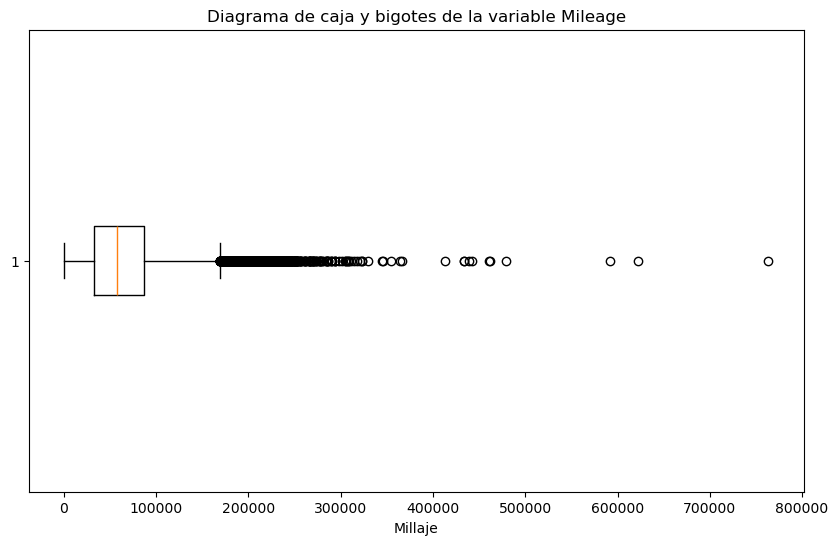

In [46]:
# Crear el boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(df['Mileage'], vert=False)  # vert=False para hacer el boxplot horizontal

# Ajustar las etiquetas y el título
plt.xlabel('Millaje')
plt.title('Diagrama de caja y bigotes de la variable Mileage')

# Mostrar el boxplot
plt.show()

Nuevamente nos encontramos con el problema de los outliers, los trataremos de la misma manera que lo hicimos con anterioridad.

In [47]:
# Calcular el rango intercuartílico (IQR)
Q1 = df['Mileage'].quantile(0.25)
Q3 = df['Mileage'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para considerar los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar los valores atípicos
df = df[(df['Mileage'] >= lower_bound) & (df['Mileage'] <= upper_bound)]

In [48]:
df["Mileage"].describe()

count   131604.00
mean     61156.91
std      36417.74
min          0.00
25%      32121.75
50%      56832.50
75%      85738.00
max     169477.00
Name: Mileage, dtype: float64

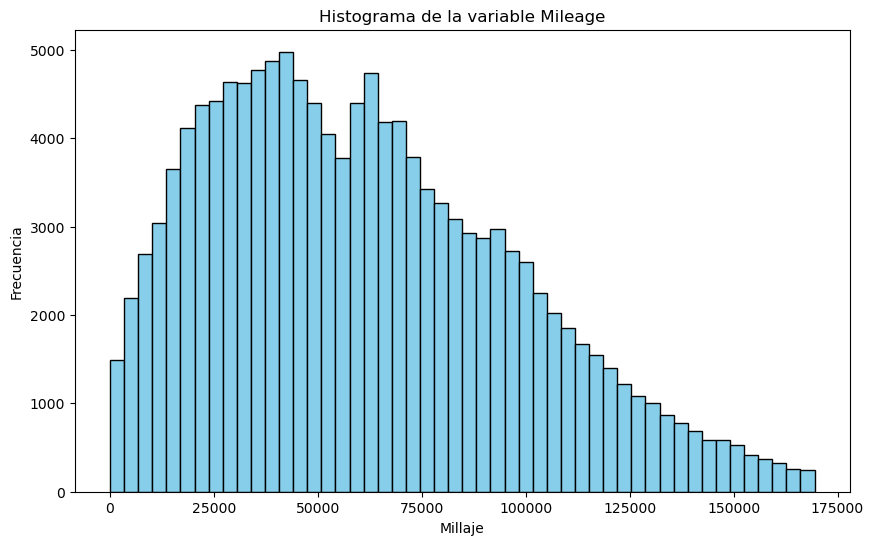

In [49]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(df['Mileage'], bins=50, color='skyblue', edgecolor='black')

# Ajustar las etiquetas y el título
plt.xlabel('Millaje')
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable Mileage')

# Mostrar el histograma
plt.show()

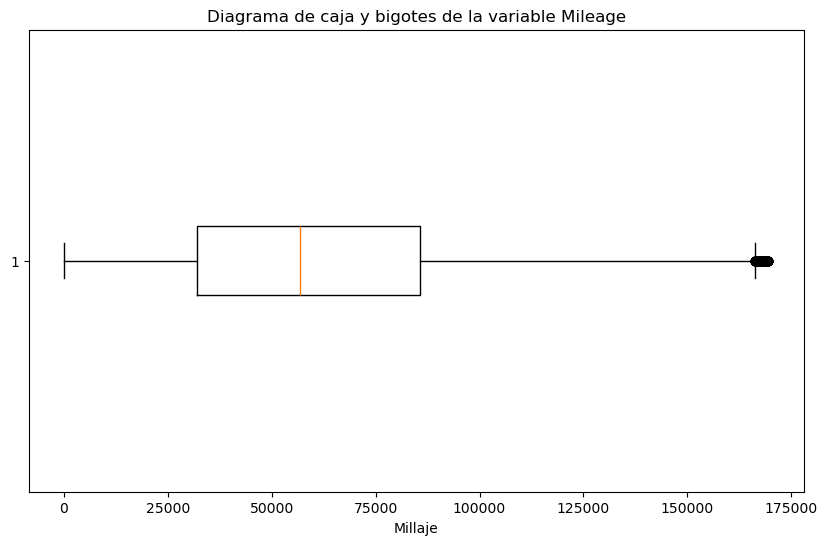

In [50]:
# Crear el boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(df['Mileage'], vert=False)  # vert=False para hacer el boxplot horizontal

# Ajustar las etiquetas y el título
plt.xlabel('Millaje')
plt.title('Diagrama de caja y bigotes de la variable Mileage')

# Mostrar el boxplot
plt.show()

Habiendo eliminado los outliers, nuestra variable "Mileage" parece tener una distribución más uniforme sin valores que se escapen demasiado.

### Seguimos creando Dummies

Seguiremos creando Dummies para aquellas columnas con variables categóricas, que sean relevantes para nuestro estudio y que no contengan demasiadas variables únicas (lo que generaría demasiadas columnas Dummy).

In [51]:
# Contar los valores únicos en la columna "columna"
value_counts0 = len(df['Brand'].unique())
value_counts1 = len(df['Drivetrain'].unique())
value_counts2 = len(df['Fuel type'].unique())
value_counts3 = len(df['Transmission'].unique())
value_counts4 = len(df['Engine'].unique())
value_counts5 = len(df['Accidents or damage'].unique())
value_counts6 = len(df['1-owner vehicle'].unique())
value_counts7 = len(df['Personal use only'].unique())

print("Recuento de valores únicos: Brand")
print(value_counts0)
print("Recuento de valores únicos: Drivetrain")
print(value_counts1)
print("Recuento de valores únicos: Fuel type")
print(value_counts2)
print("Recuento de valores únicos: Transmission")
print(value_counts3)
print("Recuento de valores únicos: Engine")
print(value_counts4)
print("Recuento de valores únicos: Accidents or damage")
print(value_counts5)
print("Recuento de valores únicos: 1-owner vehicle")
print(value_counts6)
print("Recuento de valores únicos: Personal use only")
print(value_counts7)

Recuento de valores únicos: Brand
29
Recuento de valores únicos: Drivetrain
4
Recuento de valores únicos: Fuel type
13
Recuento de valores únicos: Transmission
474
Recuento de valores únicos: Engine
996
Recuento de valores únicos: Accidents or damage
2
Recuento de valores únicos: 1-owner vehicle
2
Recuento de valores únicos: Personal use only
2


In [52]:
# Crear variables dummy para las columnas especificadas
dummy_columns = ["Drivetrain", "Fuel type", "Accidents or damage", "1-owner vehicle", "Personal use only", "Brand"]

# Duplicar las columnas originales con el sufijo _bak
bak_columns = [col + '_bak' for col in dummy_columns]
df[bak_columns] = df[dummy_columns]

# Crear variables dummy para las columnas especificadas
df = pd.get_dummies(df, columns=dummy_columns)

# Renombrar las columnas, ya que al crear los dummy algunas quedan con un espacio al final
df.rename(columns={
    'Fuel type_Compressed Natural Gas ': 'Fuel type_Compressed Natural Gas',
    'Fuel type_Gasoline/Mild Electric Hybrid ': 'Fuel type_Gasoline/Mild Electric Hybrid',
    'Fuel type_Premium Unleaded ': 'Fuel type_Premium Unleaded',
    'Fuel type_Regular Unleaded ': 'Fuel type_Regular Unleaded'
}, inplace=True)

df.reset_index(drop=True, inplace=True)

print("------------------------ INFO -------------------------")
print(df.info(verbose=True))

------------------------ INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131604 entries, 0 to 131603
Data columns (total 114 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    Name                                                        object 
 1    Year                                                        int64  
 2    Model                                                       object 
 3    Usado (tipo)                                                object 
 4    Price                                                       int64  
 5    Exterior color                                              object 
 6    Interior color                                              object 
 7    MPG                                                         object 
 8    Transmission                                                object 
 9    Engine      

In [53]:
# Seleccionar solo las columnas que son de tipo booleano
cols_booleanas = df.select_dtypes(include=bool).columns

# Convertir las columnas booleanas a 0 y 1
df[cols_booleanas] = df[cols_booleanas].astype(int)

print("------------------------ INFO -------------------------")
print(df.info(verbose=True))

------------------------ INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131604 entries, 0 to 131603
Data columns (total 114 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    Name                                                        object 
 1    Year                                                        int64  
 2    Model                                                       object 
 3    Usado (tipo)                                                object 
 4    Price                                                       int64  
 5    Exterior color                                              object 
 6    Interior color                                              object 
 7    MPG                                                         object 
 8    Transmission                                                object 
 9    Engine      

Se observa que tanto "Transmission" como "Engine" tiene una cantidad muy elevada de valores únicos por lo que sería muy complicado crear columnas Dummy a partir de ellas, afortunadamente son las menos relevantes para nuestro estudio, continuaremos creando las columnas Dummy para las otras columnas con menor número de valores únicos.

In [54]:
df.shape

(131604, 114)

Hemos quedado con poco más de 130 mil filas de datos, una cantidad bastante robusta, con esto damos por finalizada la estructuración del dataset. La ingeniería de características parece haber terminado, pero puede que más adelante debamos arreglar algo más.

## EDA (Exploratory Data Analysis - Análisis Exploratorio de Datos)

Ahora que nuestro dataset se encuentra bien estructurado, se hizo tratamiento de NaN y se desarrolló ingeniería de características podemos empezar, tranquilamente, a explorar gráficamente nuestros datos.

### Análisis Univariado

#### **Variable "Price"**

Iniciaremos el análisis con la variable "Price" la que será nuestra variable objetivo.

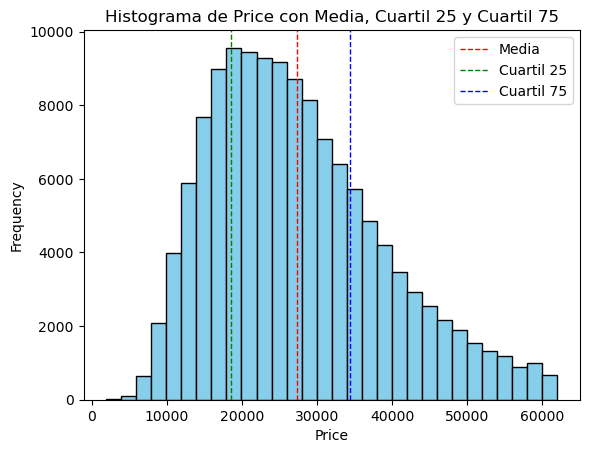

In [55]:
# Calcular la media, cuartil 25 y cuartil 75
mean_price = df['Price'].mean()
q25 = df['Price'].quantile(0.25)
q75 = df['Price'].quantile(0.75)

# Crear el histograma
plt.hist(df['Price'], bins=30, color='skyblue', edgecolor='black')

# Añadir líneas verticales para la media, cuartil 25 y cuartil 75
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(q25, color='green', linestyle='dashed', linewidth=1, label='Cuartil 25')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=1, label='Cuartil 75')

# Añadir leyenda y etiquetas
plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histograma de Price con Media, Cuartil 25 y Cuartil 75')

# Mostrar el histograma
plt.show()

Como ya habíamos visto, la distribución de la variable objetivo presenta un sesgo a la derecha, estando la media corrida hacia la derecha así como también lo está el cuartíl 25 y el 75. Podemos además observar que la mayor concentración de precios se encuentra en el rango aproximado de entre los 17.000 y los 28.000 dólares.

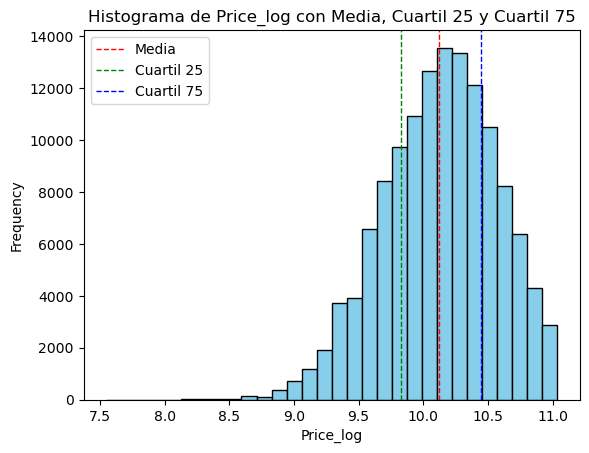

In [56]:
# Calcular la media, cuartil 25 y cuartil 75
mean_price = df['Price_log'].mean()
q25 = df['Price_log'].quantile(0.25)
q75 = df['Price_log'].quantile(0.75)

# Crear el histograma
plt.hist(df['Price_log'], bins=30, color='skyblue', edgecolor='black')

# Añadir líneas verticales para la media, cuartil 25 y cuartil 75
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(q25, color='green', linestyle='dashed', linewidth=1, label='Cuartil 25')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=1, label='Cuartil 75')

# Añadir leyenda y etiquetas
plt.legend()
plt.xlabel('Price_log')
plt.ylabel('Frequency')
plt.title('Histograma de Price_log con Media, Cuartil 25 y Cuartil 75')

# Mostrar el histograma
plt.show()

Al graficar la variable "Price_log" que corresponde a la variable "Price" transformada logarítmicamente, podemos observar una distribución más "normal" de los datos, encontrándose la media mucho más cerca del centro de mayor concentración de los datos, podemos ver que el cuartil 25 y 75 también se encuentran en posiciones más simétricas en relación a la distribución de los datos. Si bien encontramos un pequeño sesgo a la izquierda, este es mínimo en comparación al sesgo que teníamos antes de la transformación.

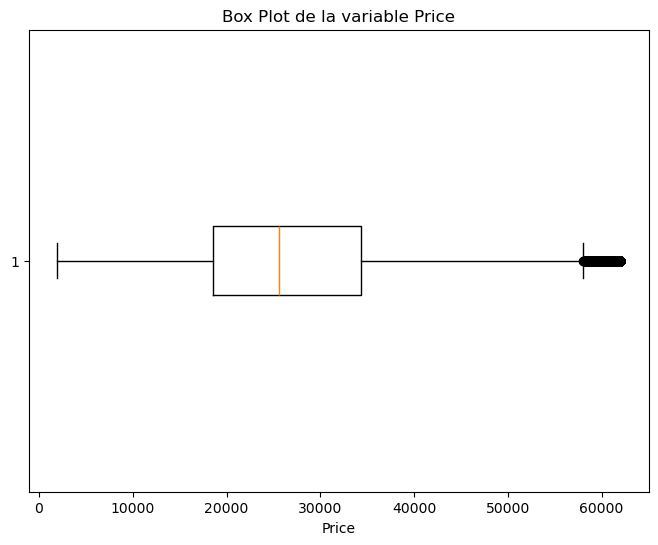

In [57]:
# Crear el box plot
plt.figure(figsize=(8, 6))
plt.boxplot(df['Price'], vert=False)  # vert=False para hacer el box plot horizontal
plt.xlabel('Price')
plt.title('Box Plot de la variable Price')
plt.show()

Observando el Boxplot de la variable Price nos podemos percatar de que la media es aproximadamente de 26.000 dólares, y que 50% central de los datos se encuentra entre los 18.000 y 34.000 dólares aproximadamente. Podemos observar algunos datos atípicos, pero estos se encuentran fuertemente agrupados en el límite superior de los bigotes de nuestro boxplot, por lo que por ahora los mantendremos por que contienen información relevante y realista sin escapar excesivamente de nuestros demás valores.

Por último identificaremos el automóvil de menor y el de mayor precio dentro de nuestro dataset.

In [58]:
# Encontrar el índice del valor mínimo de la variable Price
min_price_index = df['Price'].idxmin()
# Encontrar el índice del valor máximo de la variable Price
max_price_index = df['Price'].idxmax()

# Obtener el nombre del automóvil correspondiente al valor mínimo de Price
min_price_car = df.loc[min_price_index, 'Name']
# Obtener el nombre del automóvil correspondiente al valor máximo de Price
max_price_car = df.loc[max_price_index, 'Name']

# Obtener el valor mínimo de Price
min_price = df.loc[min_price_index, 'Price']
# Obtener el valor máximo de Price
max_price = df.loc[max_price_index, 'Price']

# Imprimir los resultados
print(f"Valor mínimo de Price: {min_price} (Automóvil: {min_price_car})")
print(f"Valor máximo de Price: {max_price} (Automóvil: {max_price_car})")

Valor mínimo de Price: 1895 (Automóvil: 2013 Chevrolet Captiva Sport Ltz)
Valor máximo de Price: 62000 (Automóvil: 2019 Cadillac Escalade Luxury)


Observamos que el automóvil de menor precio es un **Chevrolet Captiva Sport Ltz** del año **2013** el cual se vende por **1.895 dólares**, mientras que el automóvil más costoso de nuestro dataset es un **Cadillac Escalade Luxury**, del **2019**, el cual se vende por **62.000 dólares**. A primera vista, pareciera que el año de fabricación tiene especial relevancia en el precio del automóvil.

#### **Variable "Brand"**

Ahora examinaremos la variable "Brand", la que contiene la información de la marca de cada automóvil.

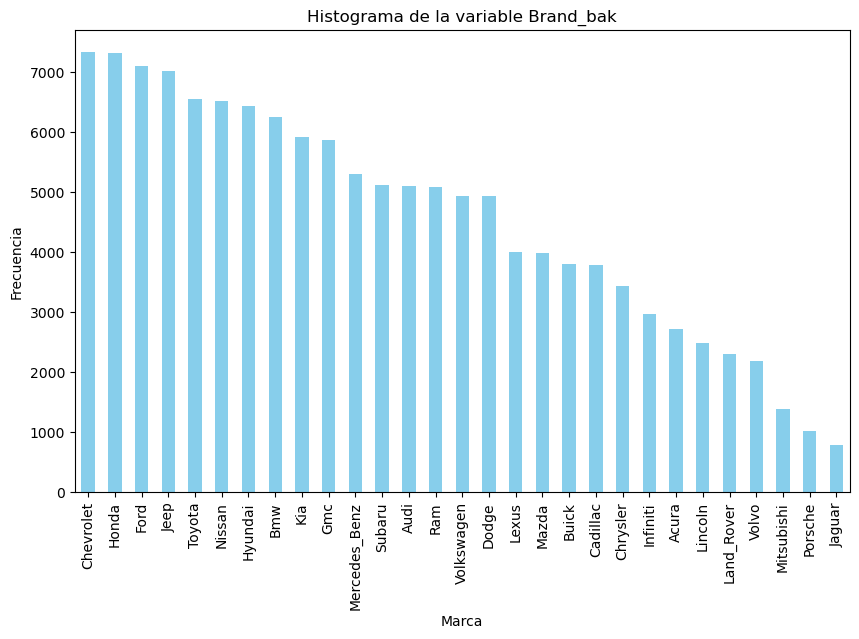

In [59]:
# Crear el histograma
plt.figure(figsize=(10, 6))
df['Brand_bak'].value_counts().plot(kind='bar', color='skyblue')

# Ajustar las etiquetas y el título
plt.xlabel('Marca')
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable Brand_bak')

# Mostrar el histograma
plt.show()

Podemos ver que existe una distribución heterogenea de los datos, siendo Chevrolet y Honda las marcas con más automóviles en el dataset, las que tienen una frecuencia más de 7 veces mayor que la variable con menos frecuencia, Jaguar. A parte de esto, no se observa nada más de interés, quizás mencionar que el dataset parece poseer mayoritariamente automóviles de gama media, media-alta.

#### **Variable "Year"**

Ahora graficaremos la columna "Year", la que contiene el año de fabricación de cada uno de los automóviles del dataset.

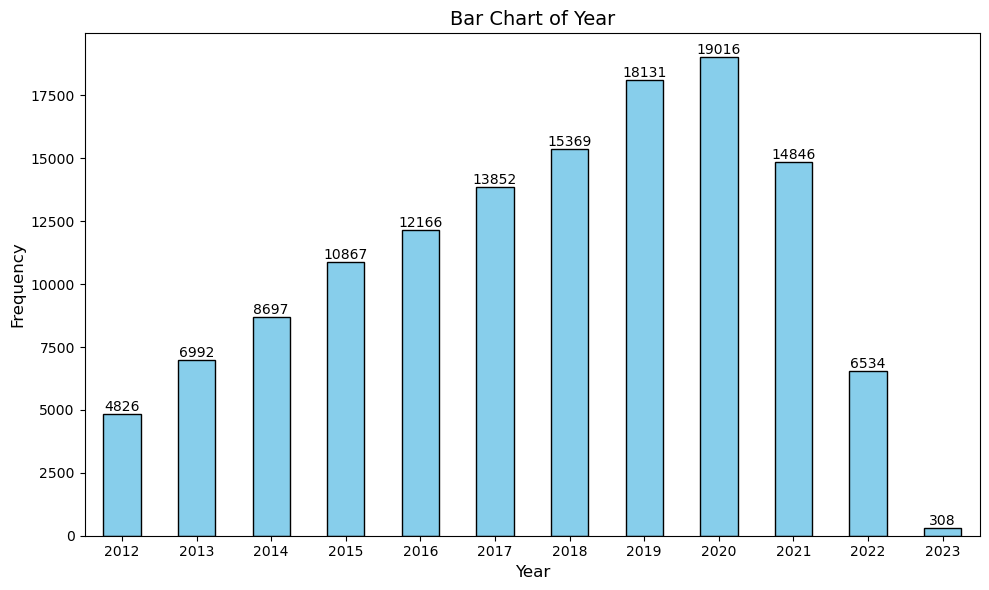

In [60]:
# Contar las frecuencias de cada año y ordenarlas
value_counts = df['Year'].value_counts().sort_index()

# Crear el gráfico de barras vertical
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Bar Chart of Year', fontsize=14)

# Agregar etiquetas con las cantidades encima de cada barra
for index, value in enumerate(value_counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

Este gráfico nos permite notar que nuestro dataset contiene automóviles cuyos años de fabricación va desde el año 2012 hasta el año 2023, siendo los del 2020 los más numerosos y los menos numerosos los del año 2023.

#### **Variable "MPG_mean"**

Ahora exploraremos la columna "MPG_mean" la que contiene el promedio de Millas Por Galón que da cada uno de nuestros automóviles, es decir, es una variable de rendimiento.

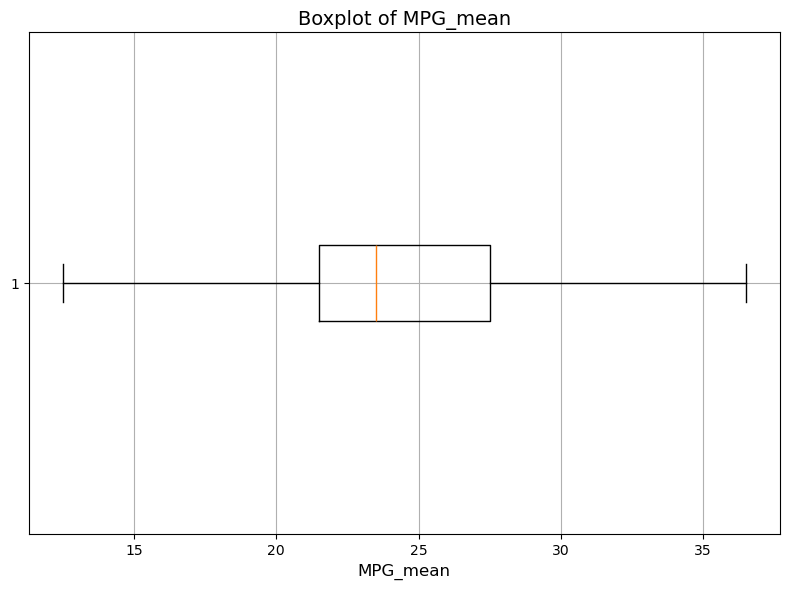

In [61]:
# Crear el gráfico de caja (boxplot) para MPG_mean
plt.figure(figsize=(8, 6))
plt.boxplot(df['MPG_mean'], vert=False)
plt.xlabel('MPG_mean', fontsize=12)
plt.title('Boxplot of MPG_mean', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

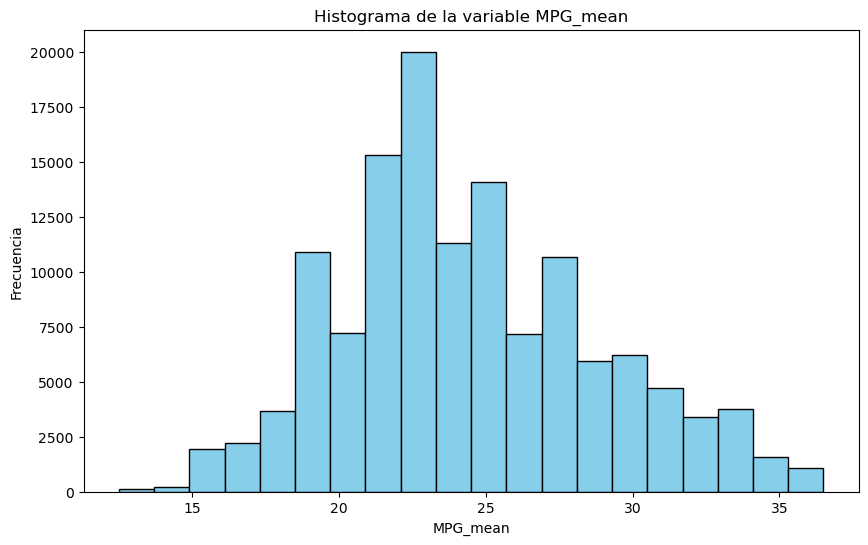

In [62]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(df['MPG_mean'], bins=20, color='skyblue', edgecolor='black')

# Ajustar las etiquetas y el título
plt.xlabel('MPG_mean')
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable MPG_mean')

# Mostrar el histograma
plt.show()

In [63]:
df["MPG_mean"].describe()

count   131604.00
mean        24.35
std          4.43
min         12.50
25%         21.50
50%         23.50
75%         27.50
max         36.50
Name: MPG_mean, dtype: float64

In [64]:
# Encontrar el índice del valor mínimo de la variable MPG_mean
min_mpg_index = df['MPG_mean'].idxmin()
# Encontrar el índice del valor máximo de la variable MPG_mean
max_mpg_index = df['MPG_mean'].idxmax()

# Obtener el nombre del automóvil correspondiente al valor mínimo de MPG_mean
min_mpg_car = df.loc[min_mpg_index, 'Name']
# Obtener el nombre del automóvil correspondiente al valor máximo de MPG_mean
max_mpg_car = df.loc[max_mpg_index, 'Name']

# Obtener el valor mínimo de MPG_mean
min_mpg = df.loc[min_mpg_index, 'MPG_mean']
# Obtener el valor máximo de MPG_mean
max_mpg = df.loc[max_mpg_index, 'MPG_mean']

# Obtener el precio correspondiente al valor mínimo de MPG_mean
min_mpg_price = df.loc[min_mpg_index, 'Price']
# Obtener el precio correspondiente al valor máximo de MPG_mean
max_mpg_price = df.loc[max_mpg_index, 'Price']

# Imprimir los resultados
print(f"Valor mínimo de MPG_mean: {min_mpg} (Automóvil: {min_mpg_car}), Precio: {min_mpg_price}")
print(f"Valor máximo de MPG_mean: {max_mpg} (Automóvil: {max_mpg_car}), Precio: {max_mpg_price}")

Valor mínimo de MPG_mean: 12.5 (Automóvil: 2017 Buick Encore Essence), Precio: 15900
Valor máximo de MPG_mean: 36.5 (Automóvil: 2015 Chevrolet Cruze Diesel), Precio: 12999


En el boxplot observamos que la eliminación de outliers se realizó de correcta manera, la media se encuentra en los 24.35 MpG, mientras que el 50% central de los datos se encuentra entre lo 21.5 y los 27.5 MpG. Por otro lado se observa que la mayor frecuencia está al rededor de las 23.5 Millas por galón. Siendo el promedio 24.35 Millas por galón, el mínimo lo posee el Buick Encore Essence, año 2017 con 12.5 MpG, con un precio de 15.900 dólares mientras que el máximo lo posee el Chevrolet Cruze Diesel, año 2015 con 36.5 MpG con un precio de 12.999 dólares. Al comienzo de este proyecto se podría pensar que el rendimiento y el precio estaban fuertemente relacionado, pero la información que acabamos de ver parece ir en contra de este supuesto, ya que el auto de mayor rendimiento del dataset es más barato que el de peor rendimiento, cabe destacar además que nuevamente el Precio parece estar invérsamente relacionado al año de fabricación. Esta observación no confirma ni refuta la suposición, pero plantea preguntas interesantes. Por esta razón, más adelante analizaremos la relación entre el precio y el rendimiento, así como entre el precio y el año de fabricación.

#### **Variable "Mileage"**

Seguimos explorando el dataset, esta vez con la variable "Mileage" que es la cantidad de millas recorridas por cada automóvil.

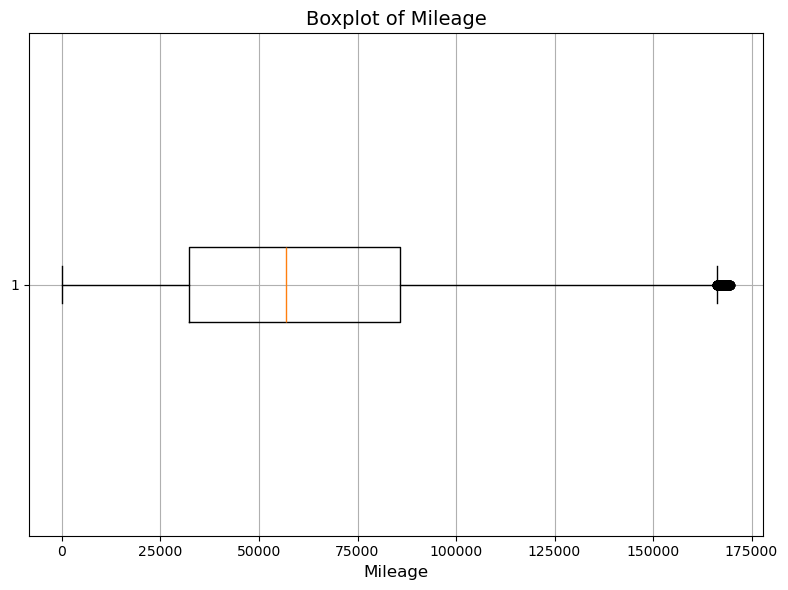

In [65]:
# Crear el gráfico de caja (boxplot)
plt.figure(figsize=(8, 6))
plt.boxplot(df['Mileage'], vert=False)
plt.xlabel('Mileage', fontsize=12)
plt.title('Boxplot of Mileage', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
df["Mileage"].describe()

count   131604.00
mean     61156.91
std      36417.74
min          0.00
25%      32121.75
50%      56832.50
75%      85738.00
max     169477.00
Name: Mileage, dtype: float64

Observamos que los datos presentan una media de poco más de 61.000 millas y el 50% de los datos centrales se encuentran entre las 32.000 y 85.000 millas. Podemos ver que existen algunos outliers compactados en el límite superior de nuestros bigotes, pero al estar tan cerca del límite y poseer información relevante y realista, los dejaremos así.

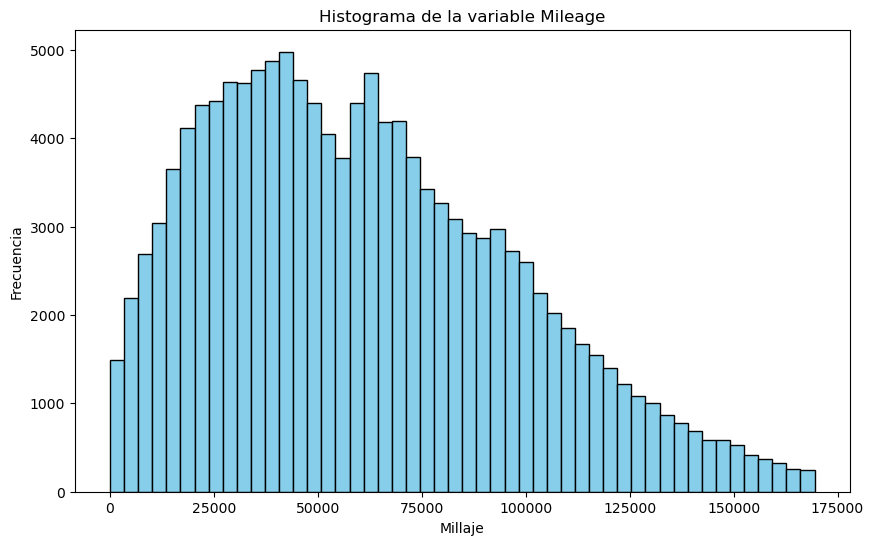

In [67]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(df['Mileage'], bins=50, color='skyblue', edgecolor='black')

# Ajustar las etiquetas y el título
plt.xlabel('Millaje')
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable Mileage')

# Mostrar el histograma
plt.show()

En el histograma se observa que la mayor frecuencia está al rededor de las 43.000 millas, y la menor frecuencia cerca de las 168.000.

#### **Variable "Drivetrain"**

Crearemos un histograma para visualizar la distribución de la variable "Drivetrain" que hace referencia al tipo de tracción de los automóviles.

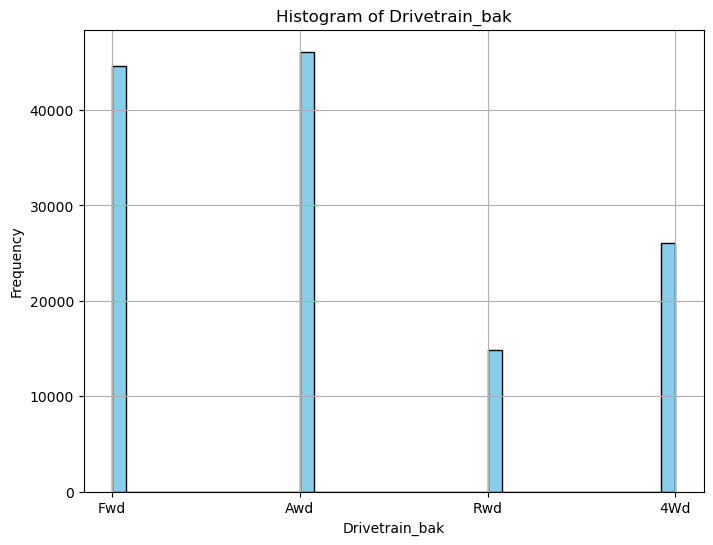

In [68]:
# Crear el histograma
plt.figure(figsize=(8, 6))
plt.hist(df['Drivetrain_bak'], bins='auto', color='skyblue', edgecolor='black')
plt.xlabel('Drivetrain_bak')
plt.ylabel('Frequency')
plt.title('Histogram of Drivetrain_bak')
plt.grid(True)
plt.show()

Observamos que más de la mitad de los automóviles pertenecen a Tracción delantera (Fwd) o Tracción en la todas las ruedas (Awd), le sigue la tracción en las 4 ruedas (4Wd) y la menos frecuente es la Tracción trasera (Rwd).

#### **Variable "Fuel type"**

Seguimos con la exploración de la columna "Fuel type" que nos habla del tipo de combustible que utiliza cada automóvil.

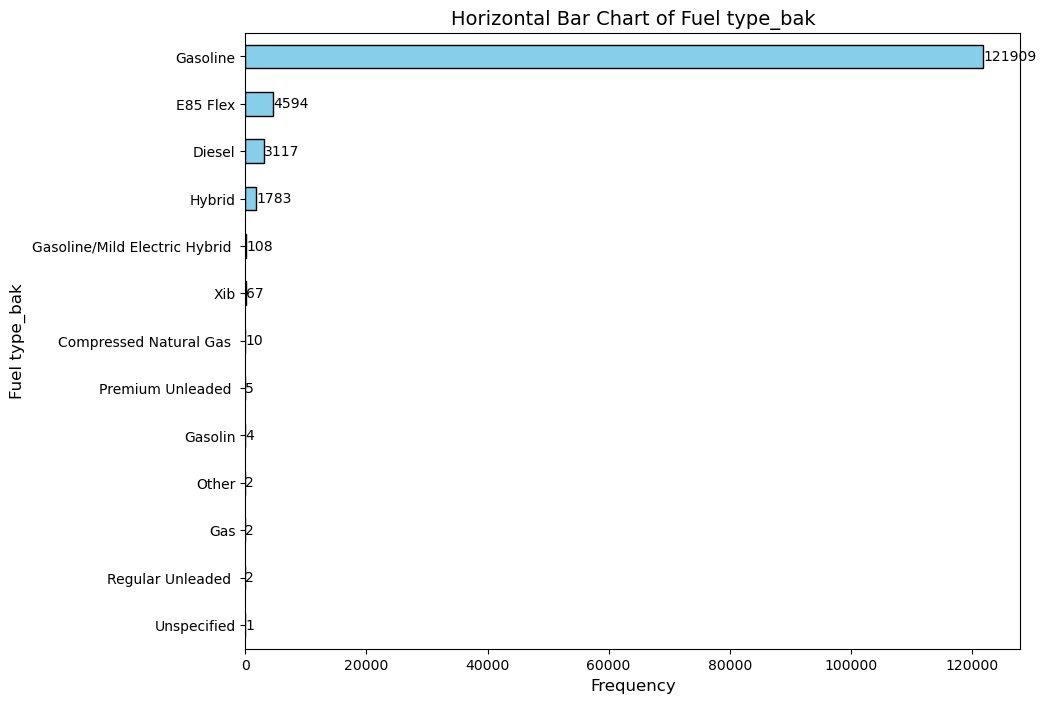

In [69]:
# Contar las frecuencias de cada valor en la columna Fuel type_bak y ordenarlas
value_counts = df['Fuel type_bak'].value_counts()

# Invertir el orden de los valores para que los más frecuentes estén abajo
value_counts = value_counts[::-1]

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 8))
value_counts.plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Fuel type_bak', fontsize=12)
plt.title('Horizontal Bar Chart of Fuel type_bak', fontsize=14)

# Agregar etiquetas con las cantidades en cada barra
for index, value in enumerate(value_counts):
    plt.text(value, index, str(value), fontsize=10, verticalalignment='center')

plt.show()

Observamos la clara diferencia en las frecuencias, destacando sin competidores la Gasolina, la que posee una frecuencia más de 26 veces mayor que el competidor más cercano, le sigue e85 Flex, una combinación de etanol y gasolina, seguido por Diesel y los vehículos Híbridos.

#### **Variable "Accidents or Damage"**

Evaluaremos la distribución de la columna "Accidents or damage" la que nos informa si el vehículo ha estado involucrado en un accidente o posee daño físico.

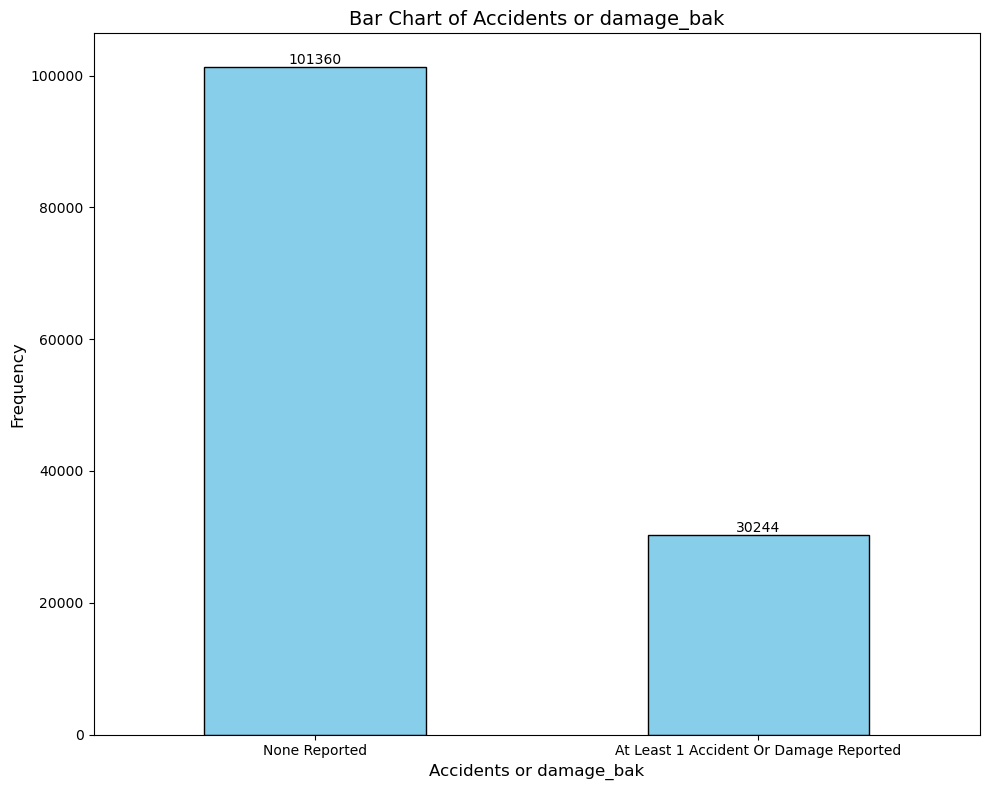

In [70]:
# Contar las frecuencias de cada valor en la columna Accidents or damage_bak y ordenarlas
value_counts = df['Accidents or damage_bak'].value_counts()

# Crear el gráfico de barras vertical
plt.figure(figsize=(10, 8))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Accidents or damage_bak', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Bar Chart of Accidents or damage_bak', fontsize=14)

# Agregar etiquetas con las cantidades encima de cada barra
for index, value in enumerate(value_counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

Se observa que más de 3/4 de los automóviles no reportan accidentes o daño alguno.

#### **Variable "1-owner vehicle"**

Ahora exploraremos la distribución de los autos según la cantidad de dueños que ha tenido.

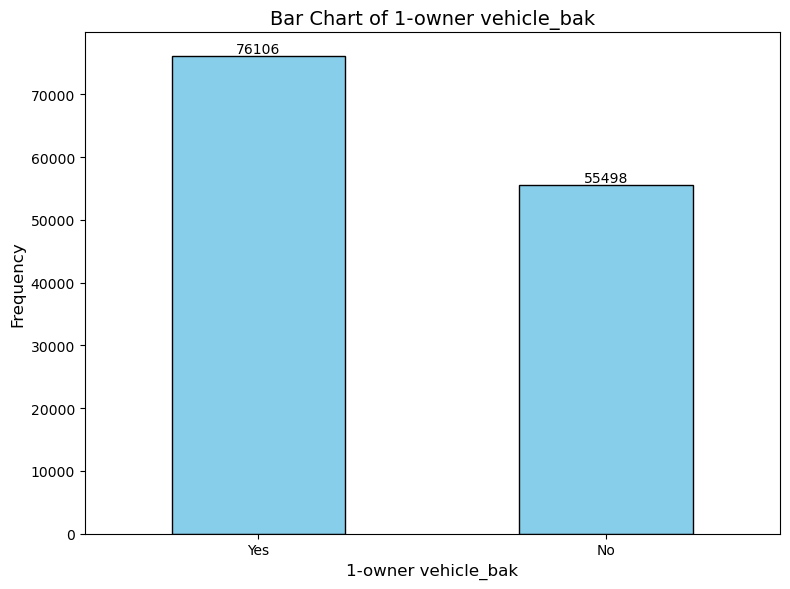

In [71]:
# Contar las frecuencias de cada valor en la columna 1-owner vehicle_bak y ordenarlas
value_counts = df['1-owner vehicle_bak'].value_counts()

# Crear el gráfico de barras vertical
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('1-owner vehicle_bak', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Bar Chart of 1-owner vehicle_bak', fontsize=14)

# Agregar etiquetas con las cantidades encima de cada barra
for index, value in enumerate(value_counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

Se observa que al rededor del 58% de los automóviles han tenido solo un dueño mientras que el otro 42% ha tenido más de uno.

#### **Variable "Personal use only"**

Por último exploraremos la columna "Personal use only", la que nos informa si el vehículo ha sido usado para uso personal o comercial.

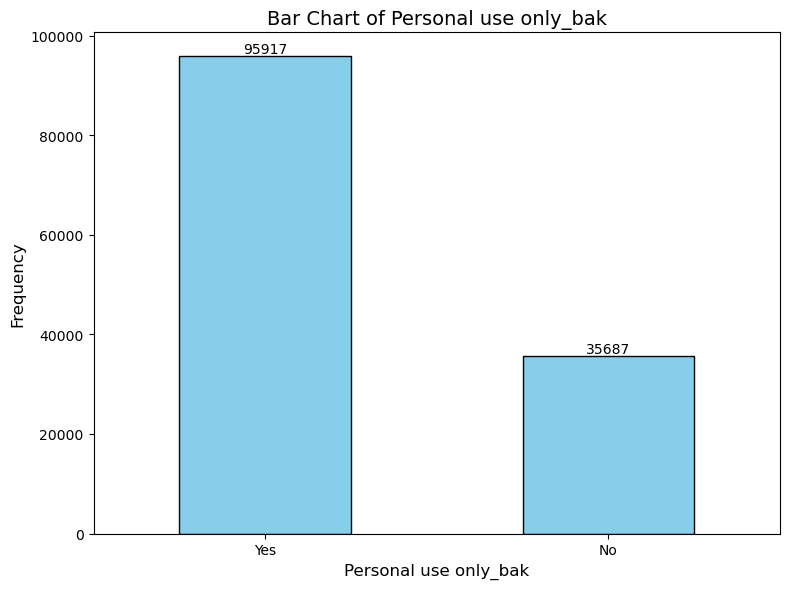

In [72]:
# Contar las frecuencias de cada valor en la columna Personal use only_bak y ordenarlas
value_counts = df['Personal use only_bak'].value_counts()

# Crear el gráfico de barras vertical
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Personal use only_bak', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Bar Chart of Personal use only_bak', fontsize=14)

# Agregar etiquetas con las cantidades encima de cada barra
for index, value in enumerate(value_counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

Se puede ver que el 73% de los automóviles han sido usados solo para efectos personales, mientras que el 27% restantes pudo haber tenido algún uso comercial o industrial.

### Análisis bivariado

#### **Price vs. Brand**

Para comenzar nuestro análisis bivariado veremos la relación que presentan las variables "Price" y "Brand", es decir la relación entre la marca del automóvil y su precio.

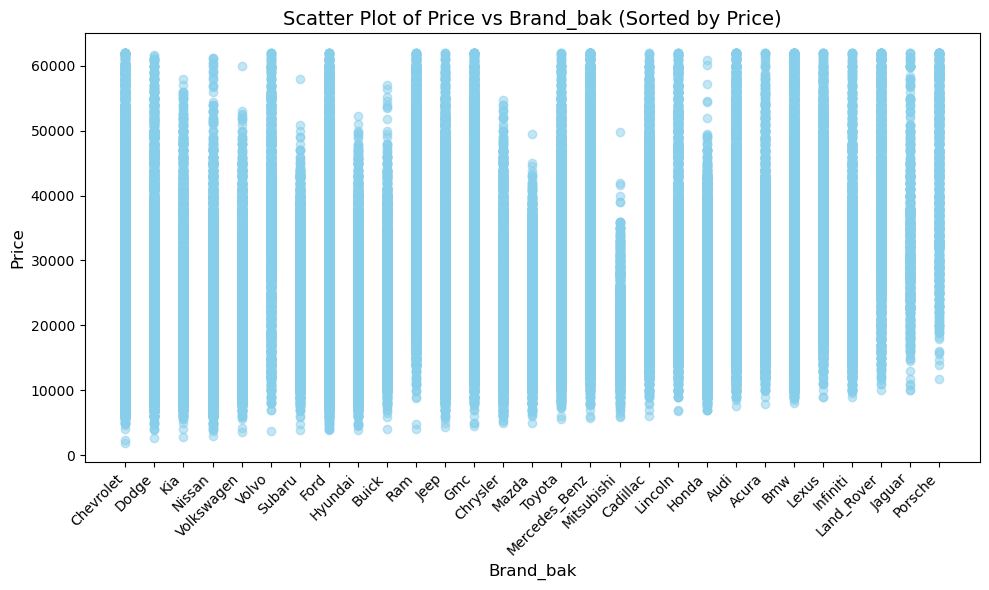

In [73]:
# Ordenar los datos por precios de menor a mayor
df_sorted = df.sort_values(by='Price')

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['Brand_bak'], df_sorted['Price'], alpha=0.5, color='skyblue')
plt.xlabel('Brand_bak', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of Price vs Brand_bak (Sorted by Price)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

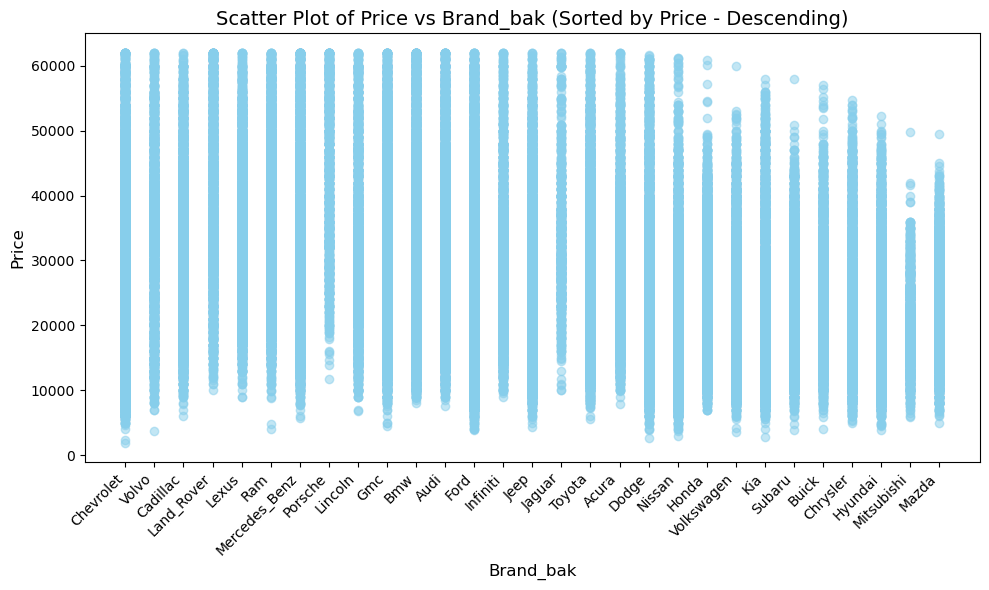

In [74]:
# Ordenar los datos por precios de mayor a menor
df_sorted = df.sort_values(by='Price', ascending=False)

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['Brand_bak'], df_sorted['Price'], alpha=0.5, color='skyblue')
plt.xlabel('Brand_bak', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of Price vs Brand_bak (Sorted by Price - Descending)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

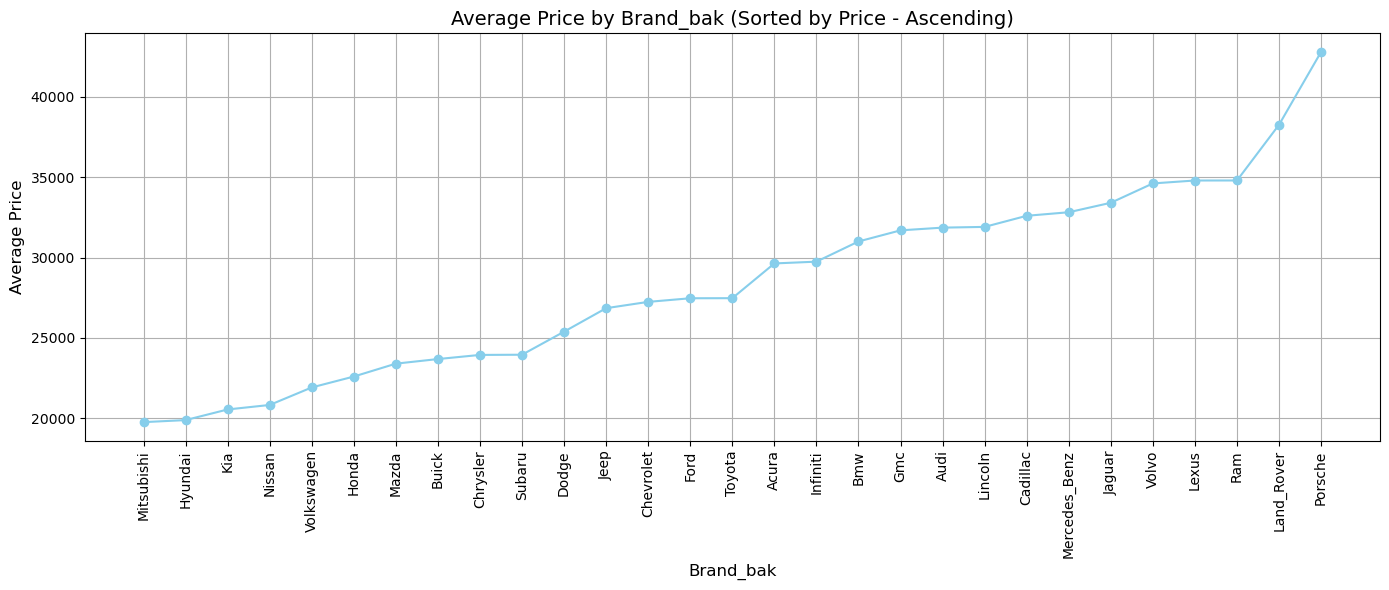

In [75]:
# Calcular el promedio de los precios para cada marca
average_price_by_brand = df.groupby('Brand_bak')['Price'].mean().sort_values()

# Crear el gráfico de líneas
plt.figure(figsize=(14, 6))  # Ajustar el tamaño de la figura
average_price_by_brand.plot(marker='o', color='skyblue', linestyle='-')
plt.xlabel('Brand_bak', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.title('Average Price by Brand_bak (Sorted by Price - Ascending)', fontsize=14)
plt.xticks(range(len(average_price_by_brand.index)), average_price_by_brand.index, rotation=90)  # Mostrar todas las etiquetas y rotarlas en 90 grados
plt.grid(True)
plt.tight_layout()
plt.show()

En los gráficos anteriores podemos observar que hay una relación clara entre la marca y el precio de los vehículos, sin embargo también es observable el hecho de que si bien hay tendencias claras, la mayoría de las marcas ofrece un amplio rango de precios. En los Scatterplot podemos ver que Porsche es la marca con los automóviles cuyos precios comienzan más alto que los de cualquier otra marca, mientras que Chevrolet se encuentra en el extremo contrario. En cuanto a los valores promedio por marca se observa que Mitsubishi es la marca con el precio promedio más bajo, aproximadamente 20.000 dólares, mientras que el valor promedio más alto se lo lleva Porsche con al rededor de 43.000 dólares. Los promedios nos permiten ver una clara relación entre Precio y Marca, mientras que los scatterplot nos hacen entender que si bien lo anterior dicho es cierto, hay más factores que influyen en el precio de un automóvil más allá de solo la marca.

#### **Price vs. Year**

Ahora exploraremos la relación que pueda haber entre "Price" y "Year", es decir, la relación entre el año de fabricación y el precio del automóvil. 

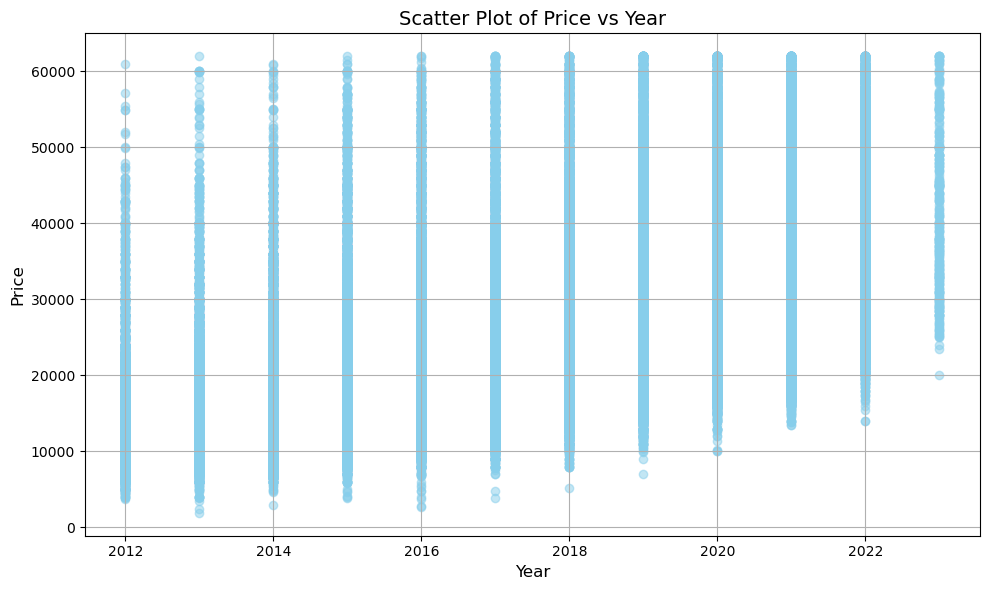

In [76]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df['Year'], df['Price'], color='skyblue', alpha=0.5)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of Price vs Year', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

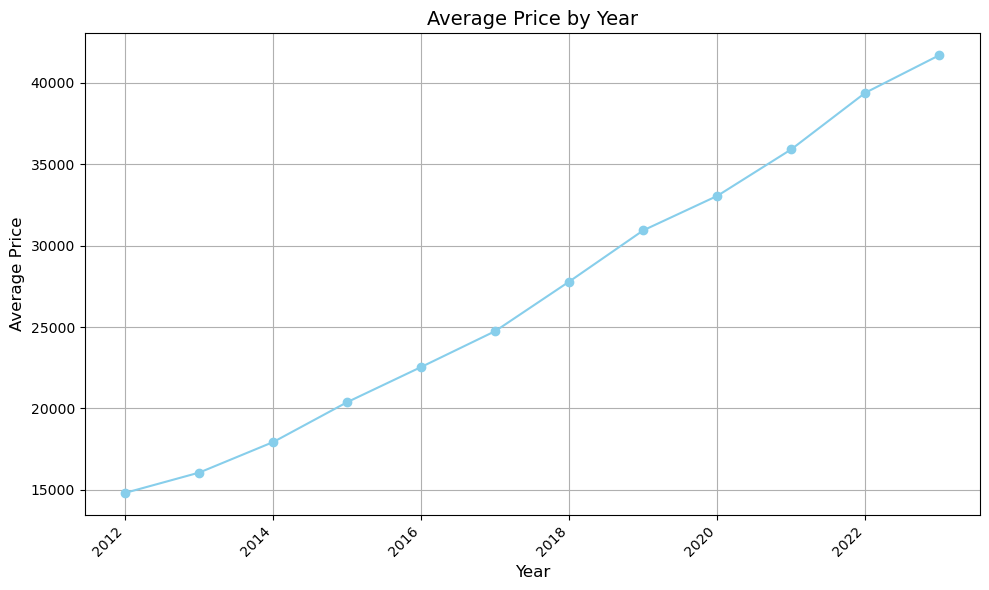

In [77]:
# Calcular el promedio de los precios para cada año
average_price_by_year = df.groupby('Year')['Price'].mean()

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
average_price_by_year.plot(marker='o', color='skyblue', linestyle='-')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.title('Average Price by Year', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Luego de analizar estos gráficos es fácil desprender que existe una relación directa entre el año de fabricación y el precio del automóvil, es decir, a medida que el año de fabricación aumenta, aumenta también el valor de dicho automóvil. Si bien como en otros casos, el año de fabricación no es el único aspecto que afecta al valor de cada automóvil pero la relación entre estas variables es fuerte y positiva. 

#### **Price vs. MPG**

Ahora analizaremos la relación entre "Price" y "MPG_mean", es decir, la relación entre el precio y las millas por galón promedio de cada auto. En otras palabras, ver la relación entre el precio y el rendimiento de cada automóvil.

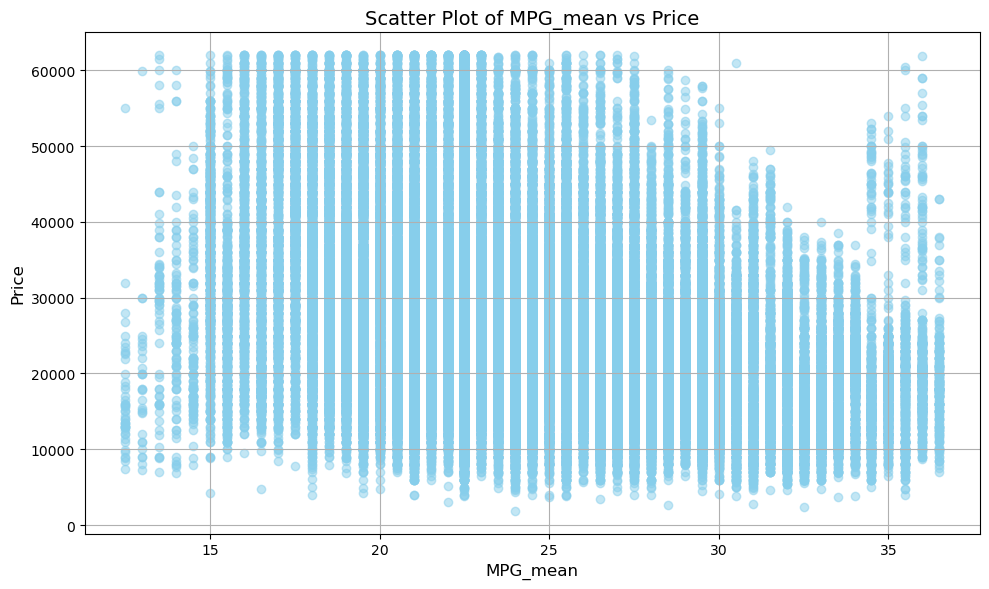

In [78]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df['MPG_mean'], df['Price'], color='skyblue', alpha=0.5)
plt.xlabel('MPG_mean', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of MPG_mean vs Price', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

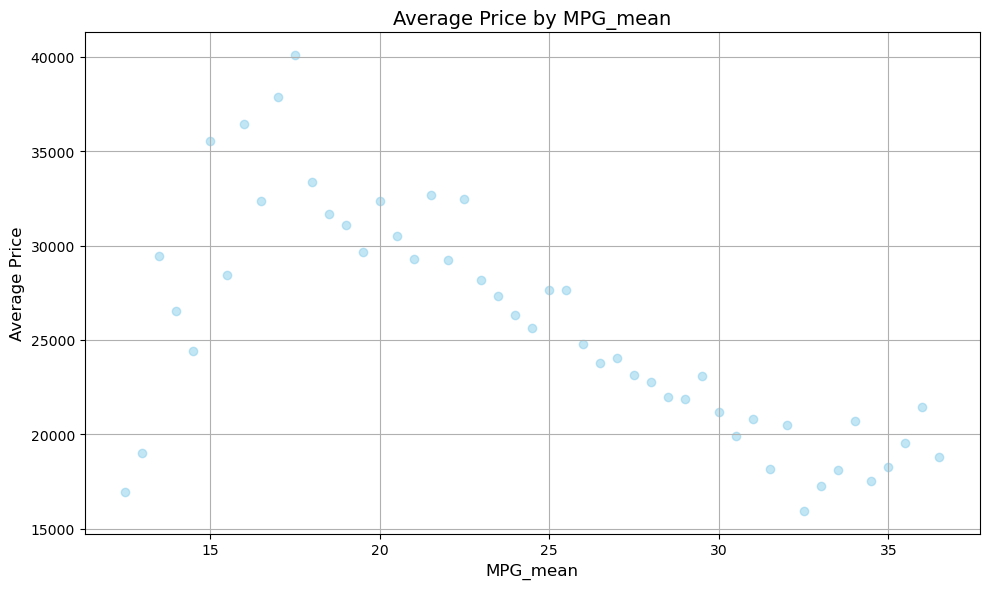

In [79]:
# Calcular el promedio de precio para cada valor de MPG_mean
average_price_by_mpg = df.groupby('MPG_mean')['Price'].mean()

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(average_price_by_mpg.index, average_price_by_mpg.values, color='skyblue', alpha=0.5)
plt.xlabel('MPG_mean', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.title('Average Price by MPG_mean', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

En este caso la relación es menos evidente, en ambos gráficos podemos observar que al principio el precio parece aumentar a medida que el rendimiento aumenta, pero llega a cierto punto (17 MpG en el segundo gráfico) desde donde comienza a bajar el precio a medida que el rendimiento aumenta. Esto parece contraintuitivo, y dificulta la interpretación y los supuestos, puede deberse a que los vehículos híbridos y otros tipos de combustibles alternativos que son más eficientes no poseen aún tanta popularidad como los combustibles más convencionales. 

#### **Price vs. Mileage**

Ahora analizaremos la relación entre el precio y la cantidad de millas recorrida por los automóviles.

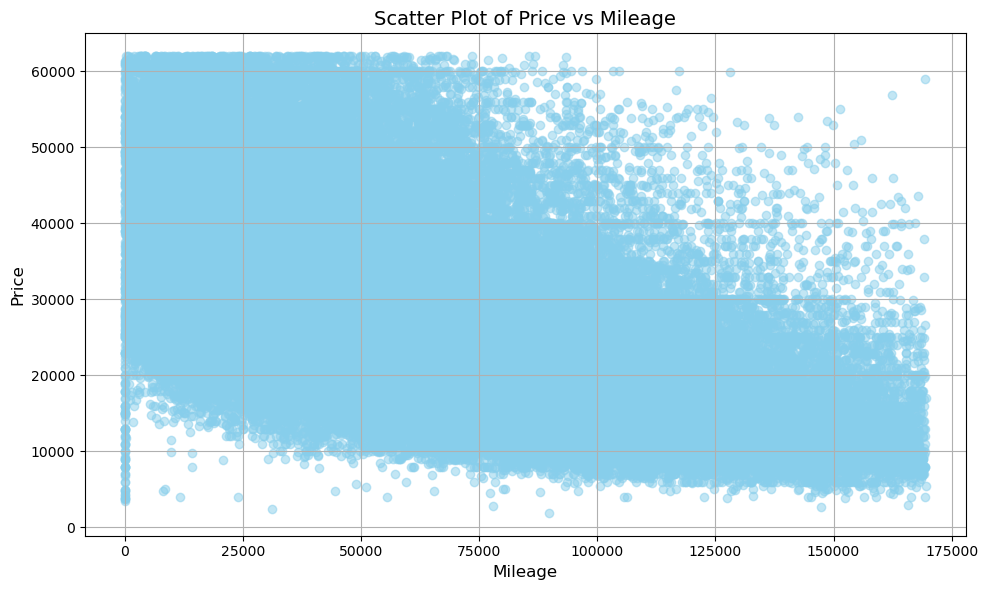

In [80]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df['Mileage'], df['Price'], color='skyblue', alpha=0.5)
plt.xlabel('Mileage', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of Price vs Mileage', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Esta vez vemos una relación mucho más clara, a pesar de que el rango de precios se encuentre en un amplio rango para cada cantidad de millas recorridas hay una tendencia clara, disminuyendo el precio del automóvil a medida que las millas recorridas aumenta, es decir, el precio y la cantidad de millas recorridas tiene una relación inversamente proporcional.

#### **Price vs. Drivetrain**

Esta vez graficaremos el tipo de tracción vs. el precio del automóvil.

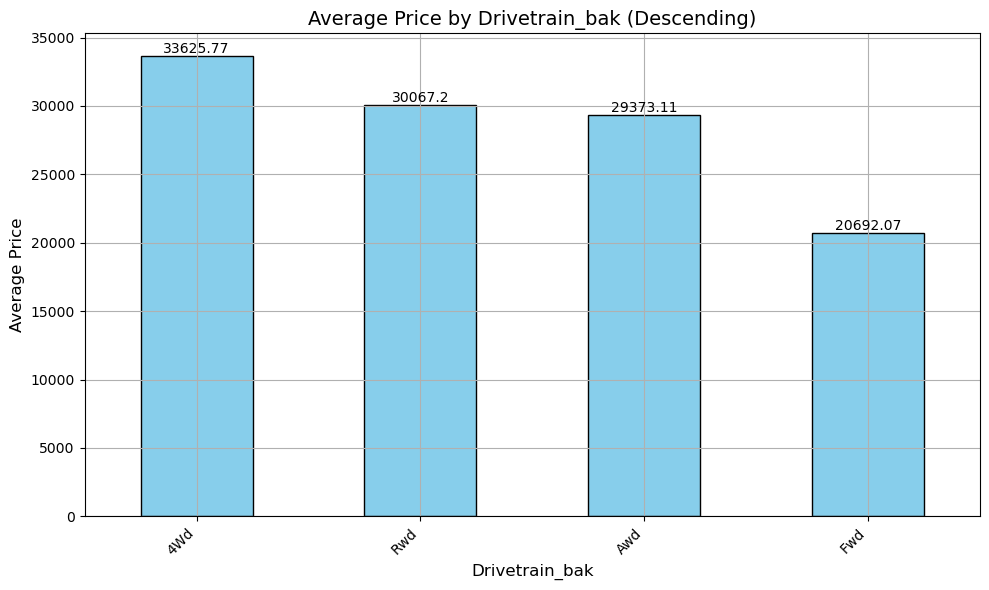

In [81]:
# Calcular el promedio de precio para cada categoría de Drivetrain_bak
average_price_by_drivetrain = df.groupby('Drivetrain_bak')['Price'].mean()

# Ordenar los datos de manera descendente
average_price_by_drivetrain = average_price_by_drivetrain.sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bar_plot = average_price_by_drivetrain.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Drivetrain_bak', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.title('Average Price by Drivetrain_bak (Descending)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Agregar etiquetas con los valores de los promedios
for index, value in enumerate(average_price_by_drivetrain):
    bar_plot.text(index, value, str(round(value, 2)), ha='center', va='bottom', fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.show()

A simple vista podemos ver que parece haber una relación entre el precio y el tipo de tracción, vemos que el promedio de precios de los automóviles con tracción en las 4 ruedas es el más alto de los 4 grupos, siendo el de tracción delantera el grupo con el precio promedio más bajo.

#### **Price vs. Fuel type**

Ahora analizaremos la relación entre el precio y el tipo de combustible.

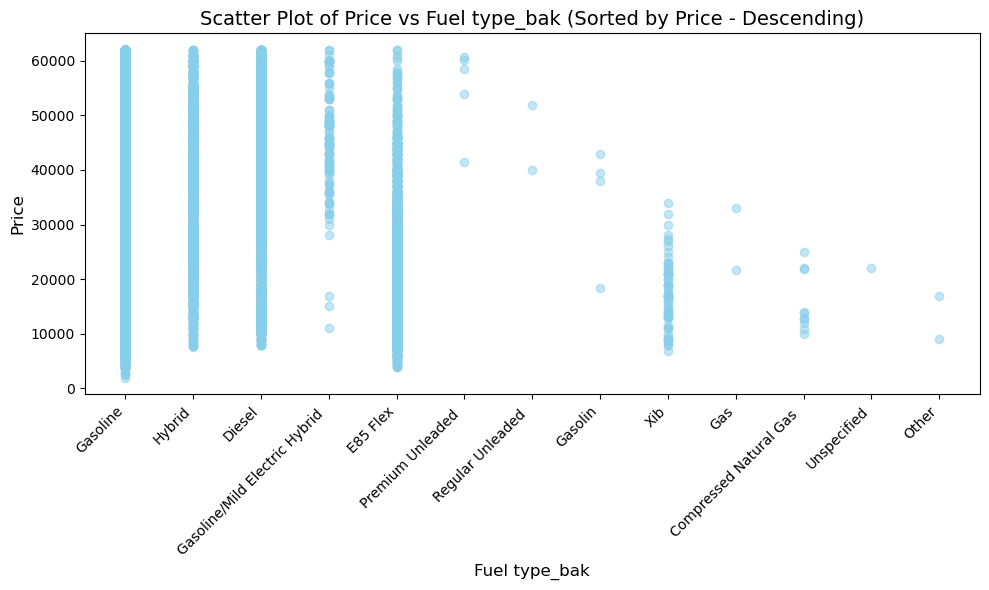

In [82]:
# Ordenar los datos por precios de mayor a menor
df_sorted = df.sort_values(by='Price', ascending=False)

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['Fuel type_bak'], df_sorted['Price'], alpha=0.5, color='skyblue')
plt.xlabel('Fuel type_bak', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of Price vs Fuel type_bak (Sorted by Price - Descending)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

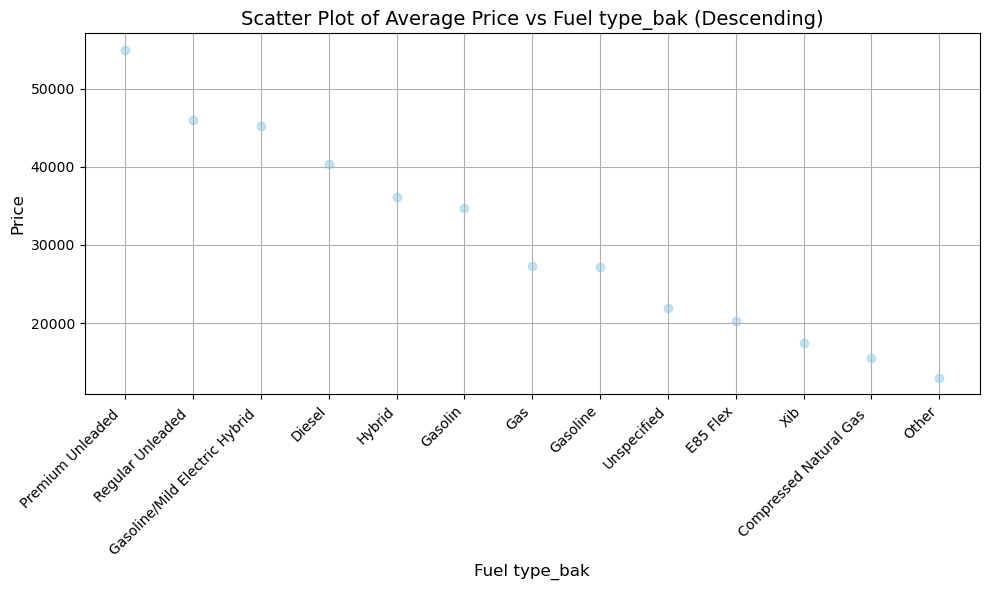

In [83]:
# Calcular el precio promedio para cada categoría de combustible
average_price_by_fuel_type = df.groupby('Fuel type_bak')['Price'].mean()

# Ordenar las categorías de combustible de manera descendente según el precio promedio
average_price_by_fuel_type = average_price_by_fuel_type.sort_values(ascending=False)

# Crear el gráfico de dispersión con las categorías de combustible ordenadas
plt.figure(figsize=(10, 6))
plt.scatter(average_price_by_fuel_type.index, df.groupby('Fuel type_bak')['Price'].mean()[average_price_by_fuel_type.index], color='skyblue', alpha=0.5)
plt.xlabel('Fuel type_bak', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of Average Price vs Fuel type_bak (Descending)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Al no haber un orden implícito entre los tipos de combustibles es difícil encontrar una relación clara entre ellos, aún así cabe destacar que los mayores precios en promedio, lo poseen aquellos autos que utilizan gasolina premium sin plomo, y regular sin plomo, y las que menores precios promedio presentan son aquellas que tienen combustibles alternativos y/o nuevos, como lo son e85 Flex (mezcla de etanol y gasolina), gas natural comprimido, y otros.

#### **Price vs. Accidents or damage**

Ahora veremos si el que un vehículo haya sido parte de un accidente o se encuentre con daños afecta el precio.

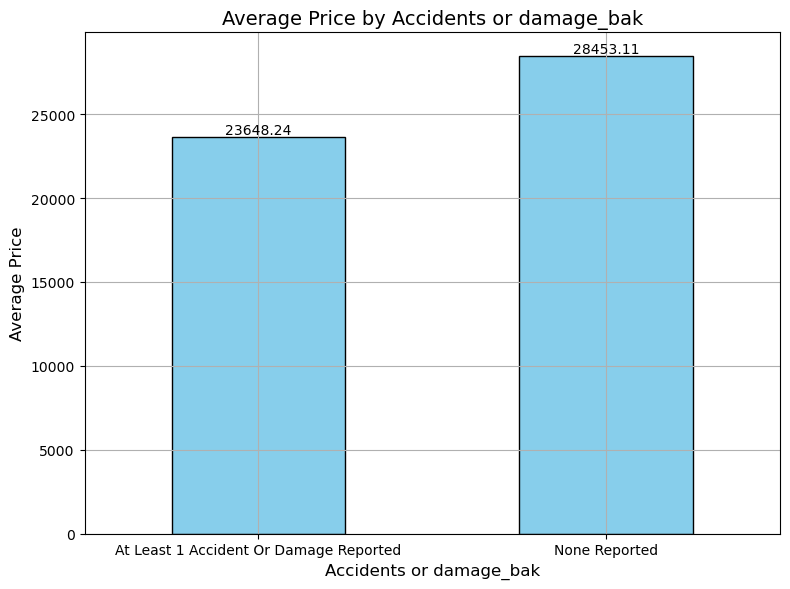

In [84]:
# Calcular el promedio de precio para cada categoría de Accidents or damage_bak
average_price_by_accident = df.groupby('Accidents or damage_bak')['Price'].mean()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
bar_plot = average_price_by_accident.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Accidents or damage_bak', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.title('Average Price by Accidents or damage_bak', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True)

# Agregar etiquetas con los valores de los promedios en cada barra
for index, value in enumerate(average_price_by_accident):
    bar_plot.text(index, value, str(round(value, 2)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

En este caso, como el sentido común haría pensar, tenemos una diferencia significativa de precios promedio en favor del grupo de vehículos que no tienen accidentes o daños reportados.

#### **Price vs. 1-owner vehicle**

Ahora veremos si el tener más de un dueño desvaloriza a los vehículos.

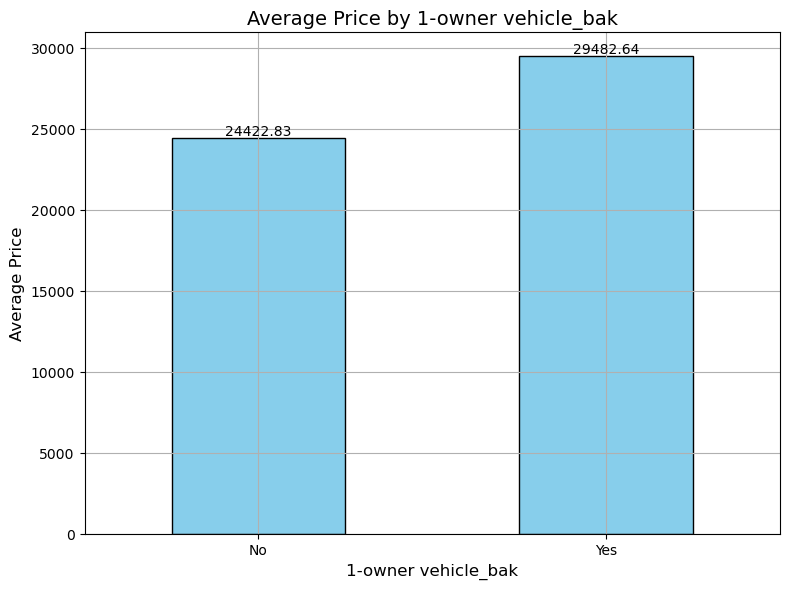

In [85]:
# Calcular el promedio de precio para cada categoría de 1-owner vehicle_bak
average_price_by_owner = df.groupby('1-owner vehicle_bak')['Price'].mean()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
bar_plot = average_price_by_owner.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('1-owner vehicle_bak', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.title('Average Price by 1-owner vehicle_bak', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True)

# Agregar etiquetas con los valores de los promedios en cada barra
for index, value in enumerate(average_price_by_owner):
    bar_plot.text(index, value, str(round(value, 2)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Podemos observar una diferencia significativa en el precio, en favor de aquellos vehículos que han tenido un solo dueño.

#### **Price vs. Personal use only**

Ahora veremos si el uso comercial de los vehículos disminuye o aumenta su valor.

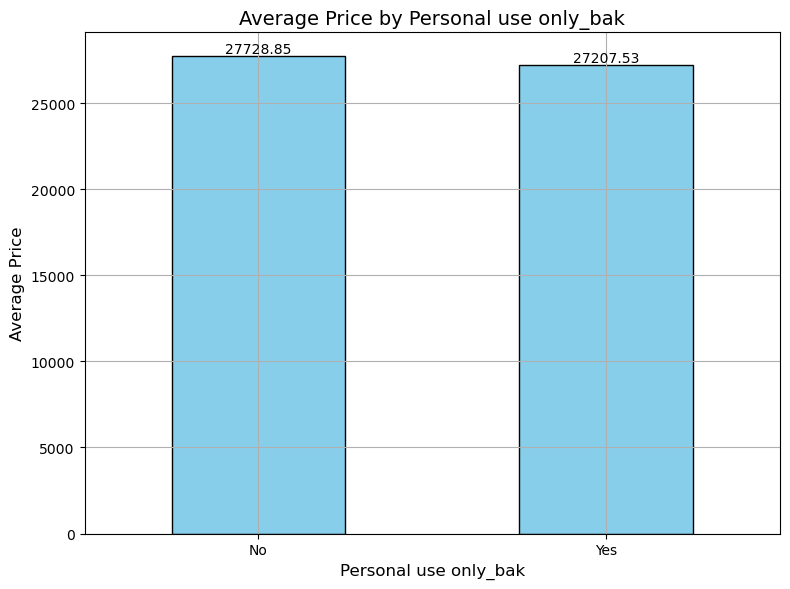

In [86]:
# Calcular el promedio de precio para cada categoría de Personal use only_bak
average_price_by_personal_use = df.groupby('Personal use only_bak')['Price'].mean()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
bar_plot = average_price_by_personal_use.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Personal use only_bak', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.title('Average Price by Personal use only_bak', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True)

# Agregar etiquetas con los valores de los promedios en cada barra
for index, value in enumerate(average_price_by_personal_use):
    bar_plot.text(index, value, str(round(value, 2)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

A simple vista no parece haber una diferencia lo suficientemente significativa entre ambos grupos.

#### **Price vs. Color**

Por último relacionaremos el precio y el color del automóvil para ver si existe alguna relación clara.

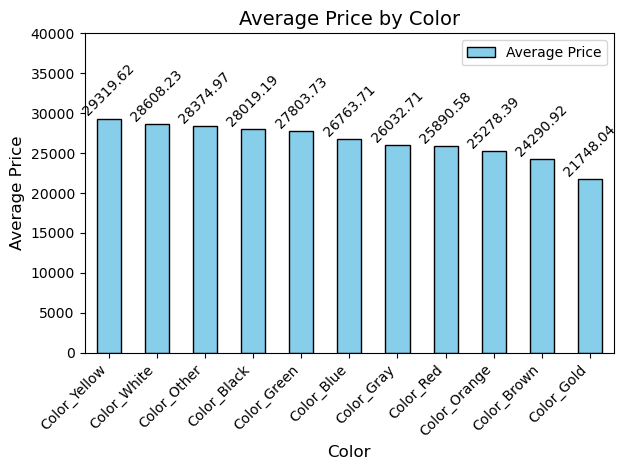

In [87]:
# Definir las columnas de color dummy
color_columns = ['Color_Black', 'Color_White', 'Color_Gray', 'Color_Red', 'Color_Blue', 'Color_Brown', 
                 'Color_Green', 'Color_Gold', 'Color_Orange', 'Color_Yellow', 'Color_Other']

# Calcular el promedio del precio para cada categoría de color
average_price_by_color = {}
for color in color_columns:
    average_price_by_color[color] = df[df[color] == 1]['Price'].mean()

# Convertir a DataFrame
average_price_df = pd.DataFrame.from_dict(average_price_by_color, orient='index', columns=['Average Price'])

# Ordenar los datos por precio de mayor a menor
average_price_df = average_price_df.sort_values(by='Average Price', ascending=False)

# Crear el gráfico de barras
bar_plot = average_price_df.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Color', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.title('Average Price by Color', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(False)

# Ajustar la escala del eje y para que llegue hasta 40000
plt.ylim(0, 40000)

# Agregar etiquetas con los valores de los promedios en cada barra
for index, value in enumerate(average_price_df['Average Price']):
    bar_plot.text(index, value, str(round(value, 2)), ha='center', va='bottom', fontsize=10, rotation=45)

plt.tight_layout()
plt.show()

A simple vista no existe una diferencia significativa entre los valores, cabe destacar que el grupo de mayor costo es el de color amarillo, algo que puede deberse a que los autos deportivos, más costosos en general, suelen tener colores llamativos como el amarillo.

## Estructuración y aplicación del Modelo de Machine Learning y Regresión Lineal

Ahora comenzaremos con la fase final del proyecto, la estructuración y aplicación del modelo. Para iniciar esta etapa identificaremos primero las 10 variables que presenten una mayor correlación con nuestra variable objetivo.

#### **Determinación de correlación**

In [88]:
# Filtra las columnas numéricas
df_numerico = df.select_dtypes(include='number')

# Calcula la matriz de correlación
matriz_correlacion = df_numerico.corr(method='pearson')

# Selecciona la variable target para estudiar únicamente correlación con ella
matriz_correlacion_target = matriz_correlacion['Price_log']

# Calcula el valor absoluto para extraer correlaciones más fuertes independientemente de su sentido
matriz_correlacion_target_abs = abs(matriz_correlacion_target)

# Excluye las variables 'Price' y 'Price_log'
matriz_correlacion_target_abs = matriz_correlacion_target_abs.drop(['Price', 'Price_log'], errors='ignore')

# Ordena de mayor a menor correlación
matriz_correlacion_target_sorted = matriz_correlacion_target_abs.sort_values(ascending=False)

# Obtiene las 10 mejores variables junto con sus correlaciones
mejores_variables = matriz_correlacion_target_sorted.head(10)

# Guarda las 10 mejores variables y sus correlaciones en una lista
lista_mejores_variables = mejores_variables.reset_index().values.tolist()

print(lista_mejores_variables)

[['Year', 0.6450456734425973], ['Mileage', 0.6178206542627275], ['Drivetrain_Fwd', 0.4343304089183628], ['Adaptive Cruise Control', 0.3827240370060201], ['Heated Seats', 0.3827240370060201], ['Cooled Seats', 0.3827240370060201], ['Keyless Start', 0.3827240370060201], ['Navigation System', 0.3827240370060201], ['Power Liftgate', 0.3827240370060201], ['Remote Start', 0.3827240370060201]]


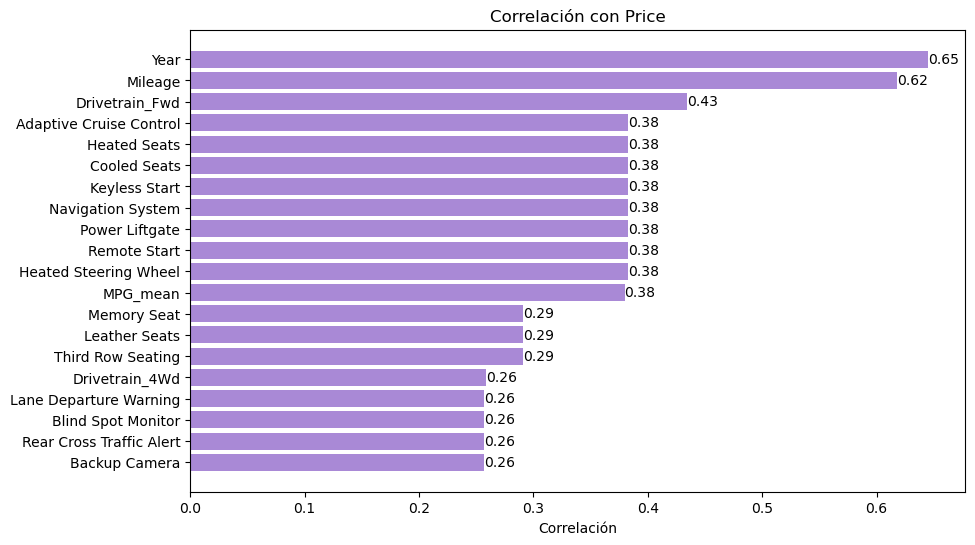

In [89]:
# Seleccionar las 20 variables con mayor correlación
matriz_correlacion_target_graficar = matriz_correlacion_target_sorted.head(20)

plt.figure(figsize=(10, 6))  # Tamaño de la figura
bars = plt.barh(matriz_correlacion_target_graficar.index, matriz_correlacion_target_graficar.values, color='#A989D6')
plt.xlabel('Correlación')
plt.title('Correlación con Price')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la característica más relevante en la parte superior

# Agregar los valores en cada barra
for bar in bars:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, round(xval, 2), va='center')

plt.show()

Como podemos observar "Year" es la variable con mayor correlación con nuestra variable objetivo, "Price", seguida de "Mileage" y luego "Drivetrain_Fwd". Es decir, aquellas variables con mayor correlación con la variable objetivo, es el año de fabricación del vehículo, "que tan viejo es", la cantidad de millas recorridas y el tipo de transmisión que posee, seguidas más lejos por características de conveniencia, es posible deducir que características como el control de temperatura para los asientos puede no ser una característica decisiva para el comprador, pero suelen estar presentes en automóviles de gama alta, y ser esta la clave de su alta correlación. Cabe destacar que MpG_mean, dicho de otro modo, el promedio de millas por galón o rendimiento de cada automóvil queda en el lugar 12 de correlación, contrastando con los supuestos del inicio.

En este punto estamos en condiciones de contrastar nuestros supuestos con la realidad:

- **La variable más fuertemente relacionada al precio es la marca del automóvil.**
    - Falso, la variable más fuertemente relacionada al precio es el Año de fabricación ("Year").  
- **La edad del auto tiene una relación inversamente proporcional con el precio.**
    - Verdadero, los automóviles más nuevos tienden a tener un valor mayor que los automóviles más viejos.
- **El rendimiento y la distancia recorrida está en el top 5 de variables más relacionadas con el precio.**
    - Falso, solo encontramos a la distancia recorrida ("Mileage") en el top 5, ocupando el puesto número 2, mientras que el rendimiento, medido en   Millas por galón ocupa el lugar 12 en la lista de correlación.
- **Los autos con combustibles alternativos/eléctricos/híbridos tienen un valor más alto.**
    - Falso, a pesar de poseer tecnología más actual, y muchas veces más eficientes en cuanto a consumo, los automóviles que utilizan combustibles alternativos suelen tener un precio más bajo que aquellos que usan combustibles más tradicionales.
- **La existencia de tracción en las 4 ruedas (4x4 o 4Wd) aumenta el valor del vehículo.**
    - Verdadero, Los vehículos con tracción en las 4 ruedas (4Wd) tienen el precio promedio más alto de todos los tipos de tracción en el dataset.

### **Definición de Variables Independientes**

Ahora, antes de comenzar la construcción de los modelos, definiremos dos listas: la primera, "xMejores_variables" contendrá las 10 mejores variables definidas por su correlación para con la variable objetivo, mientras que la segunda "xTodas_Variables" incluirá todas las variables construidas durante la etapa de feature engineering.

In [90]:
xMejores_variables = df[['Year', 'Mileage', 'Drivetrain_Fwd', 'MPG_mean', 'Remote Start', #Lista con las mejores variables.
                        'Heated Seats', 'Heated Steering Wheel', 'Adaptive Cruise Control', 
                        'Power Liftgate', 'Navigation System']]
xTodas_Variables = df[['Year', 'Mileage', 'Adaptive Cruise Control', 'Heated Seats', 'Cooled Seats', # Lista con todas las variables utilizables.
                    'Keyless Start', 'Navigation System', 'Power Liftgate', 'Remote Start', 
                    'Heated Steering Wheel', 'Apple CarPlay/Android Auto', 'USB Port', 
                    'Premium Sound System', 'Bluetooth', 'HomeLink', 'Rear Seat Entertainment', 
                    'Memory Seat', 'Third Row Seating', 'Leather Seats', 'Blind Spot Monitor', 
                    'Rear Cross Traffic Alert', 'Backup Camera', 'Lane Departure Warning', 
                    'Alloy Wheels', 'Sunroof/Moonroof', 'Tow Hitch', 'Tow Hooks', 'Color_Black', 
                    'Color_White', 'Color_Gray', 'Color_Red', 'Color_Blue', 'Color_Brown', 
                    'Color_Green', 'Color_Gold', 'Color_Orange', 'Color_Yellow', 'Color_Other', 
                    'IntColor_Black', 'IntColor_White', 'IntColor_Gray', 'IntColor_Brown', 
                    'IntColor_LightBrown', 'IntColor_Red', 'IntColor_Other', 'MPG_mean', 
                    'Drivetrain_4Wd', 'Drivetrain_Awd', 'Drivetrain_Fwd', 'Drivetrain_Rwd', 
                    'Accidents or damage_At Least 1 Accident Or Damage Reported', 
                    'Accidents or damage_None Reported', '1-owner vehicle_No', 
                    '1-owner vehicle_Yes', 'Personal use only_No', 'Personal use only_Yes', 
                    'Brand_Acura', 'Brand_Audi', 'Brand_Bmw', 'Brand_Buick', 'Brand_Cadillac', 
                    'Brand_Chevrolet', 'Brand_Chrysler', 'Brand_Dodge', 'Brand_Ford', 'Brand_Gmc', 
                    'Brand_Honda', 'Brand_Hyundai', 'Brand_Infiniti', 'Brand_Jaguar', 'Brand_Jeep', 
                    'Brand_Kia', 'Brand_Land_Rover', 'Brand_Lexus', 'Brand_Lincoln', 'Brand_Mazda', 
                    'Brand_Mercedes_Benz', 'Brand_Mitsubishi', 'Brand_Nissan', 'Brand_Porsche', 
                    'Brand_Ram', 'Brand_Subaru', 'Brand_Toyota', 'Brand_Volkswagen', 'Brand_Volvo',
                    'Fuel type_Compressed Natural Gas', 'Fuel type_Diesel', 'Fuel type_E85 Flex',
                    'Fuel type_Gas', 'Fuel type_Gasolin', 'Fuel type_Gasoline', 'Fuel type_Gasoline/Mild Electric Hybrid',
                    'Fuel type_Hybrid', 'Fuel type_Other', 'Fuel type_Premium Unleaded', 'Fuel type_Regular Unleaded',
                    'Fuel type_Unspecified', 'Fuel type_Xib']]

### **Construcción y aplicación de modelos**

Llegando al final, en esta etapa construiremos y aplicaremos diversos modelos para probar la calidad de nuestro trabajo hasta ahora y además poder evaluar que tipo de modelo actúa de mejor manera al aprender de nuestros datos. Probaremos cuatro tipos de modelos: **Regresión Lineal, Decision Tree Regressor, Random Forest Regressor y CatBoostRegressor**. Cada uno de los modelos antes mencionados será aplicado dos veces, la primera con la lista de las 10 mejores variables según su correlación con "Price" y la segunda con la lista de todas las variables. En cada caso se imprimirán y almacenarán, en un nuevo dataframe, las métricas de desempeño: **Error absoluto medio (MAE); Error cuadrático medio (MSE); Error absoluto mediano (MedAE); Coeficiente de determinación (R^2) y Tiempo de entrenamiento** (definido como el tiempo de ejecución total del modelo). Para terminar, cabe destacar que en todos los modelos se aplicará **validación cruzada** y se evaluará al modelo tanto en el conjunto de entrenamiento como en el de prueba, para así dar mayor validez y además poder evaluar la presencia de underfitting u overfitting.

### **Linear Regression**

#### **Mejores Variables**

In [91]:
# Definir las variables independientes (X) y la variable objetivo (y)
X = xMejores_variables
y = df['Price_log']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Medir el tiempo de inicio
start_time = time.time()

# Ajustar el modelo al conjunto de entrenamiento utilizando cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio negativo promedio de las validaciones cruzadas
mse_cv_mean = np.mean(scores) * -1

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Medir el tiempo de finalización del entrenamiento
training_time = time.time() - start_time

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)

# Evaluar el rendimiento del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
medae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
medae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Crear un DataFrame para almacenar las métricas
metricas_df = pd.DataFrame(data=[{
    'Modelo': 'LinearRegression',
    'Variables': 'Mejores' if np.array_equal(X, xMejores_variables) else 'Todas',
    'MAE_train': mae_train,
    'MSE_train': mse_train,
    'MedAE_train': medae_train,
    'R2_train': r2_train,
    'MAE_test': mae_test,
    'MSE_test': mse_test,
    'MedAE_test': medae_test,
    'R2_test': r2_test,
    'MSE_CV_mean': mse_cv_mean,
    'Tiempo_entrenamiento': training_time
}])

# Imprimir las métricas de evaluación para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print(f'Mean Absolute Error: {mae_train}')
print(f'Mean Squared Error: {mse_train}')
print(f'Median Absolute Error: {medae_train}')
print(f'R-squared: {r2_train}')

# Imprimir las métricas de evaluación para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Squared Error: {mse_test}')
print(f'Median Absolute Error: {medae_test}')
print(f'R-squared: {r2_test}')

# Imprimir el error cuadrático medio negativo promedio de las validaciones cruzadas
print("\nError cuadrático medio negativo promedio de las validaciones cruzadas:")
print(f'Mean Squared Error (CV): {mse_cv_mean}')

# Imprimir el tiempo de entrenamiento
print("\nTiempo de entrenamiento:", training_time, "segundos")

Métricas para el conjunto de entrenamiento:
Mean Absolute Error: 0.18185263063937065
Mean Squared Error: 0.05534506445398031
Median Absolute Error: 0.14877257646402064
R-squared: 0.7131233806207298

Métricas para el conjunto de prueba:
Mean Absolute Error: 0.18123777160057883
Mean Squared Error: 0.05483633319342504
Median Absolute Error: 0.14807081387789545
R-squared: 0.7126252309320005

Error cuadrático medio negativo promedio de las validaciones cruzadas:
Mean Squared Error (CV): 0.055351072547125214

Tiempo de entrenamiento: 0.11414623260498047 segundos


Para el primer caso, donde se utilizan las mejores variables, observamos un rendimiento bastante bueno en el conjunto de entrenamiento y de prueba, con valores bajos de Mean Absolute Error (MAE) y Mean Squared Error (MSE), lo que indica que las predicciones del modelo tienden a desviarse en promedio por menos de 0.18 unidades y el error cuadrático medio es bajo. El coeficiente de determinación (R-squared) de alrededor de 0.71 sugiere que el modelo explica aproximadamente el 71% de la variabilidad de la variable dependiente. Sin embargo, el tiempo de entrenamiento fue bajo, lo que indica una capacitación rápida y eficiente del modelo.

#### **Todas las Variables**

In [92]:
# Definir las variables independientes (X) y la variable objetivo (y)
X = xTodas_Variables
y = df['Price_log']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Medir el tiempo de inicio
start_time = time.time()

# Ajustar el modelo al conjunto de entrenamiento utilizando cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio negativo promedio de las validaciones cruzadas
mse_cv_mean = np.mean(scores) * -1

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Medir el tiempo de finalización del entrenamiento
training_time = time.time() - start_time

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)

# Evaluar el rendimiento del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
medae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
medae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Agregar las métricas al DataFrame
metricas_df.loc[len(metricas_df)] = {
    'Modelo': 'LinearRegression',
    'Variables': 'Mejores' if np.array_equal(X, xMejores_variables) else 'Todas',
    'MAE_train': mae_train,
    'MSE_train': mse_train,
    'MedAE_train': medae_train,
    'R2_train': r2_train,
    'MAE_test': mae_test,
    'MSE_test': mse_test,
    'MedAE_test': medae_test,
    'R2_test': r2_test,
    'MSE_CV_mean': mse_cv_mean,
    'Tiempo_entrenamiento': training_time
}

# Imprimir las métricas de evaluación para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print(f'Mean Absolute Error: {mae_train}')
print(f'Mean Squared Error: {mse_train}')
print(f'Median Absolute Error: {medae_train}')
print(f'R-squared: {r2_train}')

# Imprimir las métricas de evaluación para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Squared Error: {mse_test}')
print(f'Median Absolute Error: {medae_test}')
print(f'R-squared: {r2_test}')

# Imprimir el error cuadrático medio negativo promedio de las validaciones cruzadas
print("\nError cuadrático medio negativo promedio de las validaciones cruzadas:")
print(f'Mean Squared Error (CV): {mse_cv_mean}')

# Imprimir el tiempo de entrenamiento
print("\nTiempo de entrenamiento:", training_time, "segundos")

Métricas para el conjunto de entrenamiento:
Mean Absolute Error: 0.14057948232989861
Mean Squared Error: 0.03357013137639983
Median Absolute Error: 0.11369979378524064
R-squared: 0.8259919670093194

Métricas para el conjunto de prueba:
Mean Absolute Error: 0.13965463627024444
Mean Squared Error: 0.032953727796474826
Median Absolute Error: 0.11303196380125335
R-squared: 0.8273030058002284

Error cuadrático medio negativo promedio de las validaciones cruzadas:
Mean Squared Error (CV): 0.033627972895307404

Tiempo de entrenamiento: 1.032139778137207 segundos


Para el segundo caso, utilizando todas las variables, vemos una mejora en el rendimiento con respecto al primer caso. Las métricas de evaluación, tanto en el conjunto de entrenamiento como en el de prueba, han mejorado ligeramente, con valores más bajos de MAE y MSE, y un R-squared más alto, indicando que el modelo es capaz de explicar aproximadamente el 83% de la variabilidad de la variable dependiente. El tiempo de entrenamiento es considerablemente mayor debido al mayor número de variables incluidas en el modelo. En general, este modelo parece tener un mejor rendimiento que el primero en términos de precisión y capacidad de generalización.

### **Decision Tree Regressor**

#### **Mejores Variables**

In [93]:
# Medir el tiempo de inicio
start_time = time.time()

# Definir las variables
# Definir las variables independientes (X) y la variable objetivo (y)
X = xMejores_variables
y = df['Price_log']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo DecisionTreeRegressor
dt = DecisionTreeRegressor()

# Ajustar el modelo al conjunto de entrenamiento utilizando cross-validation
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio negativo promedio de las validaciones cruzadas
mse_cv_mean = np.mean(scores) * -1

# Ajustar el modelo al conjunto de entrenamiento
dt.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = dt.predict(X_train)

# Evaluar el rendimiento del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
medae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = dt.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
medae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Medir el tiempo de finalización
training_time = time.time() - start_time

# Agregar las métricas al DataFrame
metricas_df.loc[len(metricas_df)] = {
    'Modelo': 'DecisionTreeRegressor',
    'Variables': 'Mejores' if np.array_equal(X, xMejores_variables) else 'Todas',
    'MAE_train': mae_train,
    'MSE_train': mse_train,
    'MedAE_train': medae_train,
    'R2_train': r2_train,
    'MAE_test': mae_test,
    'MSE_test': mse_test,
    'MedAE_test': medae_test,
    'R2_test': r2_test,
    'MSE_CV_mean': mse_cv_mean,
    'Tiempo_entrenamiento': training_time
}

# Imprimir las métricas de evaluación para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print(f'Mean Absolute Error: {mae_train}')
print(f'Mean Squared Error: {mse_train}')
print(f'Median Absolute Error: {medae_train}')
print(f'R-squared: {r2_train}')

# Imprimir las métricas de evaluación para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Squared Error: {mse_test}')
print(f'Median Absolute Error: {medae_test}')
print(f'R-squared: {r2_test}')

# Imprimir el error cuadrático medio negativo promedio de las validaciones cruzadas
print("\nError cuadrático medio negativo promedio de las validaciones cruzadas:")
print(f'Mean Squared Error (CV): {mse_cv_mean}')

# Imprimir el tiempo de ejecución
print("\nTiempo de ejecución:", training_time, "segundos")

Métricas para el conjunto de entrenamiento:
Mean Absolute Error: 0.0004865581599240943
Mean Squared Error: 9.953900306619034e-05
Median Absolute Error: 0.0
R-squared: 0.9994840477108893

Métricas para el conjunto de prueba:
Mean Absolute Error: 0.21577932914947745
Mean Squared Error: 0.08312659428615789
Median Absolute Error: 0.16381955831829842
R-squared: 0.564367556230799

Error cuadrático medio negativo promedio de las validaciones cruzadas:
Mean Squared Error (CV): 0.08384152541321295

Tiempo de ejecución: 1.1699163913726807 segundos


Para el primer caso, utilizando un DecisionTreeRegressor con las mejores variables, observamos un rendimiento excepcionalmente alto en el conjunto de entrenamiento, con un R-squared cercano a 1, lo que indica que el modelo ajusta casi perfectamente los datos de entrenamiento. Sin embargo, en el conjunto de prueba, vemos una diferencia significativa en el rendimiento, con un MAE y un MSE mucho más altos, lo que indica que el modelo no generaliza tan bien para datos no vistos. Esto sugiere un sobreajuste del modelo a los datos de entrenamiento. Aunque el tiempo de entrenamiento fue relativamente bajo, el modelo requiere mayor capacidad de generalización.

#### **Todas las Variables**

In [94]:
# Medir el tiempo de inicio
start_time = time.time()

# Definir las variables
# Definir las variables independientes (X) y la variable objetivo (y)
X = xTodas_Variables
y = df['Price_log']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo DecisionTreeRegressor
dt = DecisionTreeRegressor()

# Ajustar el modelo al conjunto de entrenamiento utilizando cross-validation
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio negativo promedio de las validaciones cruzadas
mse_cv_mean = np.mean(scores) * -1

# Ajustar el modelo al conjunto de entrenamiento
dt.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = dt.predict(X_train)

# Evaluar el rendimiento del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
medae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = dt.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
medae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Medir el tiempo de finalización
training_time = time.time() - start_time

# Agregar las métricas al DataFrame
metricas_df.loc[len(metricas_df)] = {
    'Modelo': 'DecisionTreeRegressor',
    'Variables': 'Mejores' if np.array_equal(X, xMejores_variables) else 'Todas',
    'MAE_train': mae_train,
    'MSE_train': mse_train,
    'MedAE_train': medae_train,
    'R2_train': r2_train,
    'MAE_test': mae_test,
    'MSE_test': mse_test,
    'MedAE_test': medae_test,
    'R2_test': r2_test,
    'MSE_CV_mean': mse_cv_mean,
    'Tiempo_entrenamiento': training_time
}

# Imprimir las métricas de evaluación para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print(f'Mean Absolute Error: {mae_train}')
print(f'Mean Squared Error: {mse_train}')
print(f'Median Absolute Error: {medae_train}')
print(f'R-squared: {r2_train}')

# Imprimir las métricas de evaluación para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Squared Error: {mse_test}')
print(f'Median Absolute Error: {medae_test}')
print(f'R-squared: {r2_test}')

# Imprimir el error cuadrático medio negativo promedio de las validaciones cruzadas
print("\nError cuadrático medio negativo promedio de las validaciones cruzadas:")
print(f'Mean Squared Error (CV): {mse_cv_mean}')

# Imprimir el tiempo de ejecución
print("\nTiempo de ejecución:", training_time, "segundos")

Métricas para el conjunto de entrenamiento:
Mean Absolute Error: 5.418047427043169e-06
Mean Squared Error: 4.760654469281243e-07
Median Absolute Error: 0.0
R-squared: 0.999997532353655

Métricas para el conjunto de prueba:
Mean Absolute Error: 0.1326863167924425
Mean Squared Error: 0.0336942736375754
Median Absolute Error: 0.09861250147132239
R-squared: 0.8234221082697556

Error cuadrático medio negativo promedio de las validaciones cruzadas:
Mean Squared Error (CV): 0.03512003557725504

Tiempo de ejecución: 5.015121221542358 segundos


Para el segundo caso, con todas las variables, nuevamente observamos un rendimiento excepcionalmente alto en el conjunto de entrenamiento, con un R-squared cercano a 1. Sin embargo, en el conjunto de prueba, aunque el modelo generaliza mejor que en el primer caso, aún muestra un MAE y un MSE significativamente más altos en comparación con el conjunto de entrenamiento. Esto sugiere que aunque el modelo generaliza mejor que antes, aún puede haber algún grado de sobreajuste. El tiempo de entrenamiento fue considerablemente mayor debido al mayor número de variables. En general, este modelo parece tener un mejor rendimiento que el primero en términos de capacidad de generalización, pero aún puede mejorar en la capacidad de predecir datos no vistos.

### **Random Forest Regressor**

#### **Mejores Variables**

In [95]:
# Medir el tiempo de inicio
start_time = time.time()

# Definir las variables
# Definir las variables independientes (X) y la variable objetivo (y)
X = xMejores_variables
y = df['Price_log']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)

# Ajustar el modelo al conjunto de entrenamiento utilizando cross-validation
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio negativo promedio de las validaciones cruzadas
mse_cv_mean = np.mean(scores) * -1

# Ajustar el modelo al conjunto de entrenamiento
rf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = rf.predict(X_train)

# Evaluar el rendimiento del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
medae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = rf.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
medae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Medir el tiempo de finalización
training_time = time.time() - start_time

# Agregar las métricas al DataFrame
metricas_df.loc[len(metricas_df)] = {
    'Modelo': 'RandomForestRegressor',
    'Variables': 'Mejores' if np.array_equal(X, xMejores_variables) else 'Todas',
    'MAE_train': mae_train,
    'MSE_train': mse_train,
    'MedAE_train': medae_train,
    'R2_train': r2_train,
    'MAE_test': mae_test,
    'MSE_test': mse_test,
    'MedAE_test': medae_test,
    'R2_test': r2_test,
    'MSE_CV_mean': mse_cv_mean,
    'Tiempo_entrenamiento': training_time
}

# Imprimir las métricas de evaluación para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print(f'Mean Absolute Error: {mae_train}')
print(f'Mean Squared Error: {mse_train}')
print(f'Median Absolute Error: {medae_train}')
print(f'R-squared: {r2_train}')

# Imprimir las métricas de evaluación para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Squared Error: {mse_test}')
print(f'Median Absolute Error: {medae_test}')
print(f'R-squared: {r2_test}')

# Imprimir el error cuadrático medio negativo promedio de las validaciones cruzadas
print("\nError cuadrático medio negativo promedio de las validaciones cruzadas:")
print(f'Mean Squared Error (CV): {mse_cv_mean}')

# Imprimir el tiempo de ejecución
print("\nTiempo de ejecución:", training_time, "segundos")

Métricas para el conjunto de entrenamiento:
Mean Absolute Error: 0.06422719169064081
Mean Squared Error: 0.007383125933678201
Median Absolute Error: 0.04905540689351895
R-squared: 0.9617301699943599

Métricas para el conjunto de prueba:
Mean Absolute Error: 0.17320930499775408
Mean Squared Error: 0.05276846786142428
Median Absolute Error: 0.1332308360729062
R-squared: 0.7234620664321301

Error cuadrático medio negativo promedio de las validaciones cruzadas:
Mean Squared Error (CV): 0.052757053325022174

Tiempo de ejecución: 103.35537219047546 segundos


Para el primer caso, utilizando un RandomForestRegressor con las mejores variables, observamos un buen rendimiento tanto en el conjunto de entrenamiento como en el conjunto de prueba. El modelo tiene un buen R-squared en ambos conjuntos, indicando que es capaz de explicar alrededor del 96% de la variabilidad en los datos de entrenamiento y alrededor del 72% en los datos de prueba. Sin embargo, hay una diferencia entre las métricas de entrenamiento y prueba, lo que sugiere cierto grado de sobreajuste. El tiempo de entrenamiento fue significativamente largo debido a la complejidad del modelo y el tiempo necesario para ajustar múltiples árboles de decisión.

#### **Todas las Variables**

In [96]:
# Medir el tiempo de inicio
start_time = time.time()

# Definir las variables
# Definir las variables independientes (X) y la variable objetivo (y)
X = xTodas_Variables
y = df['Price_log']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)

# Ajustar el modelo al conjunto de entrenamiento utilizando cross-validation
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio negativo promedio de las validaciones cruzadas
mse_cv_mean = np.mean(scores) * -1

# Ajustar el modelo al conjunto de entrenamiento
rf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = rf.predict(X_train)

# Evaluar el rendimiento del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
medae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = rf.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
medae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Medir el tiempo de finalización
training_time = time.time() - start_time

# Agregar las métricas al DataFrame
metricas_df.loc[len(metricas_df)] = {
    'Modelo': 'RandomForestRegressor',
    'Variables': 'Mejores' if np.array_equal(X, xMejores_variables) else 'Todas',
    'MAE_train': mae_train,
    'MSE_train': mse_train,
    'MedAE_train': medae_train,
    'R2_train': r2_train,
    'MAE_test': mae_test,
    'MSE_test': mse_test,
    'MedAE_test': medae_test,
    'R2_test': r2_test,
    'MSE_CV_mean': mse_cv_mean,
    'Tiempo_entrenamiento': training_time
}

# Imprimir las métricas de evaluación para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print(f'Mean Absolute Error: {mae_train}')
print(f'Mean Squared Error: {mse_train}')
print(f'Median Absolute Error: {medae_train}')
print(f'R-squared: {r2_train}')

# Imprimir las métricas de evaluación para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Squared Error: {mse_test}')
print(f'Median Absolute Error: {medae_test}')
print(f'R-squared: {r2_test}')

# Imprimir el error cuadrático medio negativo promedio de las validaciones cruzadas
print("\nError cuadrático medio negativo promedio de las validaciones cruzadas:")
print(f'Mean Squared Error (CV): {mse_cv_mean}')

# Imprimir el tiempo de ejecución
print("\nTiempo de ejecución:", training_time, "segundos")

Métricas para el conjunto de entrenamiento:
Mean Absolute Error: 0.03629455189350973
Mean Squared Error: 0.0025142096820182152
Median Absolute Error: 0.027151774011956675
R-squared: 0.9869677995480924

Métricas para el conjunto de prueba:
Mean Absolute Error: 0.09769425598653383
Mean Squared Error: 0.017580944517728073
Median Absolute Error: 0.07416006120120144
R-squared: 0.9078654684484776

Error cuadrático medio negativo promedio de las validaciones cruzadas:
Mean Squared Error (CV): 0.018539832973360128

Tiempo de ejecución: 341.07259035110474 segundos


Para el segundo caso, utilizando todas las variables, observamos una mejora en el rendimiento del modelo tanto en el conjunto de entrenamiento como en el conjunto de prueba. El modelo tiene un R-squared más alto en ambos conjuntos, indicando que es capaz de explicar aproximadamente el 99% de la variabilidad en los datos de entrenamiento y alrededor del 91% en los datos de prueba. Aunque hay una ligera diferencia entre las métricas de entrenamiento y prueba, la diferencia es menor en comparación con el primer caso, lo que sugiere una mejor generalización. Sin embargo, el tiempo de entrenamiento fue mucho mayor debido a la complejidad adicional del modelo al incluir todas las variables. En general, este modelo parece tener un mejor rendimiento que el primero en términos de precisión y capacidad de generalización, pero requiere más tiempo para entrenar.

### **Cat Boost Regressor**

#### **Mejores Variables**

In [97]:
# Medir el tiempo de inicio
start_time = time.time()

# Definir las variables
# Definir las variables independientes (X) y la variable objetivo (y)
X = xMejores_variables
y = df['Price_log']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo CatBoostRegressor
cb = CatBoostRegressor(verbose=False)

# Ajustar el modelo al conjunto de entrenamiento utilizando cross-validation
scores = cross_val_score(cb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio negativo promedio de las validaciones cruzadas
mse_cv_mean = np.mean(scores) * -1

# Ajustar el modelo al conjunto de entrenamiento
cb.fit(X_train, y_train, verbose=False)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = cb.predict(X_train)

# Evaluar el rendimiento del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
medae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = cb.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
medae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Medir el tiempo de finalización
training_time = time.time() - start_time

# Agregar las métricas al DataFrame
metricas_df.loc[len(metricas_df)] = {
    'Modelo': 'CatBoostRegressor',
    'Variables': 'Mejores' if np.array_equal(X, xMejores_variables) else 'Todas',
    'MAE_train': mae_train,
    'MSE_train': mse_train,
    'MedAE_train': medae_train,
    'R2_train': r2_train,
    'MAE_test': mae_test,
    'MSE_test': mse_test,
    'MedAE_test': medae_test,
    'R2_test': r2_test,
    'MSE_CV_mean': mse_cv_mean,
    'Tiempo_entrenamiento': training_time
}

# Imprimir las métricas de evaluación para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print(f'Mean Absolute Error: {mae_train}')
print(f'Mean Squared Error: {mse_train}')
print(f'Median Absolute Error: {medae_train}')
print(f'R-squared: {r2_train}')

# Imprimir las métricas de evaluación para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Squared Error: {mse_test}')
print(f'Median Absolute Error: {medae_test}')
print(f'R-squared: {r2_test}')

# Imprimir el error cuadrático medio negativo promedio de las validaciones cruzadas
print("\nError cuadrático medio negativo promedio de las validaciones cruzadas:")
print(f'Mean Squared Error (CV): {mse_cv_mean}')

# Imprimir el tiempo de ejecución
print("\nTiempo de ejecución:", training_time, "segundos")

Métricas para el conjunto de entrenamiento:
Mean Absolute Error: 0.1537743191045612
Mean Squared Error: 0.04045949538571215
Median Absolute Error: 0.12256015202866877
R-squared: 0.7902815115935864

Métricas para el conjunto de prueba:
Mean Absolute Error: 0.15566465762132328
Mean Squared Error: 0.041460788208345443
Median Absolute Error: 0.12383945316980771
R-squared: 0.7827209854691906

Error cuadrático medio negativo promedio de las validaciones cruzadas:
Mean Squared Error (CV): 0.04215913333307998

Tiempo de ejecución: 16.89973282814026 segundos


Para el primer caso, utilizando un CatBoostRegressor con las mejores variables, observamos un buen rendimiento en ambos conjuntos de entrenamiento y prueba. El modelo tiene un R-squared decente tanto en el conjunto de entrenamiento como en el conjunto de prueba, lo que indica que es capaz de explicar alrededor del 79% de la variabilidad en los datos de entrenamiento y alrededor del 78% en los datos de prueba. Las métricas de evaluación, como el MAE y el MSE, son relativamente bajos, lo que sugiere que el modelo tiene una buena capacidad de predicción. El tiempo de ejecución fue moderado, lo que indica una velocidad razonable en el entrenamiento del modelo.

#### **Todas las Variables**

In [98]:
# Medir el tiempo de inicio
start_time = time.time()

# Definir las variables
# Definir las variables independientes (X) y la variable objetivo (y)
X = xTodas_Variables
y = df['Price_log']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo CatBoostRegressor
cb = CatBoostRegressor(verbose=False)

# Ajustar el modelo al conjunto de entrenamiento utilizando cross-validation
scores = cross_val_score(cb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio negativo promedio de las validaciones cruzadas
mse_cv_mean = np.mean(scores) * -1

# Ajustar el modelo al conjunto de entrenamiento
cb.fit(X_train, y_train, verbose=False)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = cb.predict(X_train)

# Evaluar el rendimiento del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
medae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = cb.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
medae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Medir el tiempo de finalización
training_time = time.time() - start_time

# Agregar las métricas al DataFrame
metricas_df.loc[len(metricas_df)] = {
    'Modelo': 'CatBoostRegressor',
    'Variables': 'Mejores' if np.array_equal(X, xMejores_variables) else 'Todas',
    'MAE_train': mae_train,
    'MSE_train': mse_train,
    'MedAE_train': medae_train,
    'R2_train': r2_train,
    'MAE_test': mae_test,
    'MSE_test': mse_test,
    'MedAE_test': medae_test,
    'R2_test': r2_test,
    'MSE_CV_mean': mse_cv_mean,
    'Tiempo_entrenamiento': training_time
}

# Imprimir las métricas de evaluación para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print(f'Mean Absolute Error: {mae_train}')
print(f'Mean Squared Error: {mse_train}')
print(f'Median Absolute Error: {medae_train}')
print(f'R-squared: {r2_train}')

# Imprimir las métricas de evaluación para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Squared Error: {mse_test}')
print(f'Median Absolute Error: {medae_test}')
print(f'R-squared: {r2_test}')

# Imprimir el error cuadrático medio negativo promedio de las validaciones cruzadas
print("\nError cuadrático medio negativo promedio de las validaciones cruzadas:")
print(f'Mean Squared Error (CV): {mse_cv_mean}')

# Imprimir el tiempo de ejecución
print("\nTiempo de ejecución:", training_time, "segundos")

Métricas para el conjunto de entrenamiento:
Mean Absolute Error: 0.09354613417814561
Mean Squared Error: 0.015653627669640256
Median Absolute Error: 0.07313345185231945
R-squared: 0.9188607000246208

Métricas para el conjunto de prueba:
Mean Absolute Error: 0.09633123399934221
Mean Squared Error: 0.01643891423905744
Median Absolute Error: 0.07569243794033831
R-squared: 0.9138503815250687

Error cuadrático medio negativo promedio de las validaciones cruzadas:
Mean Squared Error (CV): 0.016945519343127224

Tiempo de ejecución: 19.606584787368774 segundos


Para el segundo caso, utilizando todas las variables, observamos una mejora en el rendimiento del modelo en comparación con el primer caso. El modelo tiene un R-squared más alto tanto en el conjunto de entrenamiento como en el conjunto de prueba, lo que indica una mejor capacidad para explicar la variabilidad en los datos. Las métricas de evaluación, como el MAE y el MSE, también son más bajos en comparación con el primer caso, lo que sugiere una mejor capacidad de predicción. El tiempo de ejecución fue un poco mayor que en el primer caso debido a la mayor complejidad del modelo al incluir todas las variables. En general, este modelo parece tener un mejor rendimiento que el primero en términos de precisión y capacidad de generalización, pero requiere un tiempo de entrenamiento ligeramente mayor.

### **Visualizando los resultados**

Ahora que hemos terminado de ejecutar los modelos, utilizaremos nuestro nuevo df que contiene los datos de las métricas obtenidas en cada uno de ellos.

Primero crearemos columnas extras en nuestro df de métricas que contengan la eficiencia del modelo, definido como el cociente entre el R2 del conjunto de prueba y el tiempo de entrenamiento, es decir, los segundos de ejecución que le toma al modelo ganar un punto porcentual de R2, por lo tanto a mayor valor, menor eficiencia. También incluiremos una columna con la pérdida de R2 entre el conjunto de entrenamiento y el de prueba, haremos lo mismo para cada métrica.

In [99]:
# Calcular el resultado de la división de R2_test por Tiempo_entrenamiento
metricas_df['Eficiencia'] = metricas_df['Tiempo_entrenamiento'] / (metricas_df['R2_test']*100)

# Calcular la pérdida de R2 al pasar al conjunto de prueba
metricas_df['Perdida_R2'] = metricas_df['R2_train'] - metricas_df['R2_test']

# Calcular la diferencia de MAE
metricas_df['Diferencia_MAE'] = metricas_df['MAE_train'] - metricas_df['MAE_test']

# Calcular la diferencia de MSE
metricas_df['Diferencia_MSE'] = metricas_df['MSE_train'] - metricas_df['MSE_test']

# Calcular la diferencia de MedAE
metricas_df['Diferencia_MedAE'] = metricas_df['MedAE_train'] - metricas_df['MedAE_test']

In [100]:
metricas_df

,Modelo,Variables,MAE_train,MSE_train,MedAE_train,R2_train,MAE_test,MSE_test,MedAE_test,R2_test,MSE_CV_mean,Tiempo_entrenamiento,Eficiencia,Perdida_R2,Diferencia_MAE,Diferencia_MSE,Diferencia_MedAE
0,LinearRegression,Mejores,0.18,0.06,0.15,0.71,0.18,0.05,0.15,0.71,0.06,0.11,0.00,0.00,0.00,0.00,0.00
1,LinearRegression,Todas,0.14,0.03,0.11,0.83,0.14,0.03,0.11,0.83,0.03,1.03,0.01,-0.00,0.00,0.00,0.00
2,DecisionTreeRegressor,Mejores,0.00,0.00,0.00,1.00,0.22,0.08,0.16,0.56,0.08,1.17,0.02,0.44,-0.22,-0.08,-0.16
3,DecisionTreeRegressor,Todas,0.00,0.00,0.00,1.00,0.13,0.03,0.10,0.82,0.04,5.02,0.06,0.18,-0.13,-0.03,-0.10
4,RandomForestRegressor,Mejores,0.06,0.01,0.05,0.96,0.17,0.05,0.13,0.72,0.05,103.36,1.43,0.24,-0.11,-0.05,-0.08
5,RandomForestRegressor,Todas,0.04,0.00,0.03,0.99,0.10,0.02,0.07,0.91,0.02,341.07,3.76,0.08,-0.06,-0.02,-0.05
6,CatBoostRegressor,Mejores,0.15,0.04,0.12,0.79,0.16,0.04,0.12,0.78,0.04,16.90,0.22,0.01,-0.00,-0.00,-0.00
7,CatBoostRegressor,Todas,0.09,0.02,0.07,0.92,0.10,0.02,0.08,0.91,0.02,19.61,0.21,0.01,-0.00,-0.00,-0.00


#### **Graficando R2 de prueba**

Ahora graficaremos el R2 del conjunto de prueba que corresponda al resultado obtenido para cada uno de los modelos ejecutados.

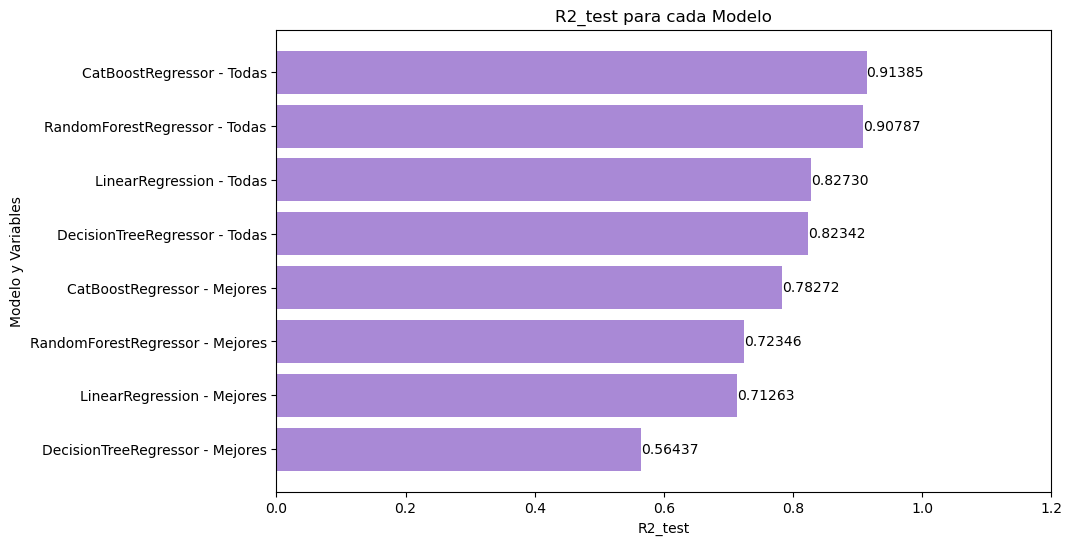

In [101]:
# Ordenar el DataFrame por R2_test de menor a mayor
metricas_df_sorted = metricas_df.sort_values(by='R2_test')

# Generar nombres para cada dato basados en la suma de las columnas "Modelo" y "Variables"
nombres_datos = metricas_df_sorted['Modelo'] + ' - ' + metricas_df_sorted['Variables']

# Graficar R2_test
plt.figure(figsize=(10, 6))
barras = plt.barh(nombres_datos, metricas_df_sorted['R2_test'], color='#A989D6')
plt.xlabel('R2_test')
plt.ylabel('Modelo y Variables')
plt.title('R2_test para cada Modelo')

# Establecer límites del eje x
plt.xlim(0, 1.2)

# Agregar los valores de R2_test a cada barra con tres decimales adicionales
for barra in barras:
    valor = barra.get_width()
    plt.text(valor, barra.get_y() + barra.get_height() / 2, f'{valor:.5f}', ha='left', va='center')

plt.show()

Se puede observar que aquellos modelos que utilizaron todas las variables disponibles obtuvieron mejores resultados que su contraparte que usó solo el conjunto de las 10 variables con mayor correlación con "price". El ganador en esta métrica es el Modelo - CatBoostRegressor (Todas), alcanzando un 91,3% de explicación de la variable.

#### **Graficando eficiencia**

Ahora graficaremos la eficiencia, que como vimos con anterioridad la definimos como los segundos de ejecuciónque le toma al modelo ganar un punto porcentual de R2, por lo tanto a mayor valor, menor eficiencia.

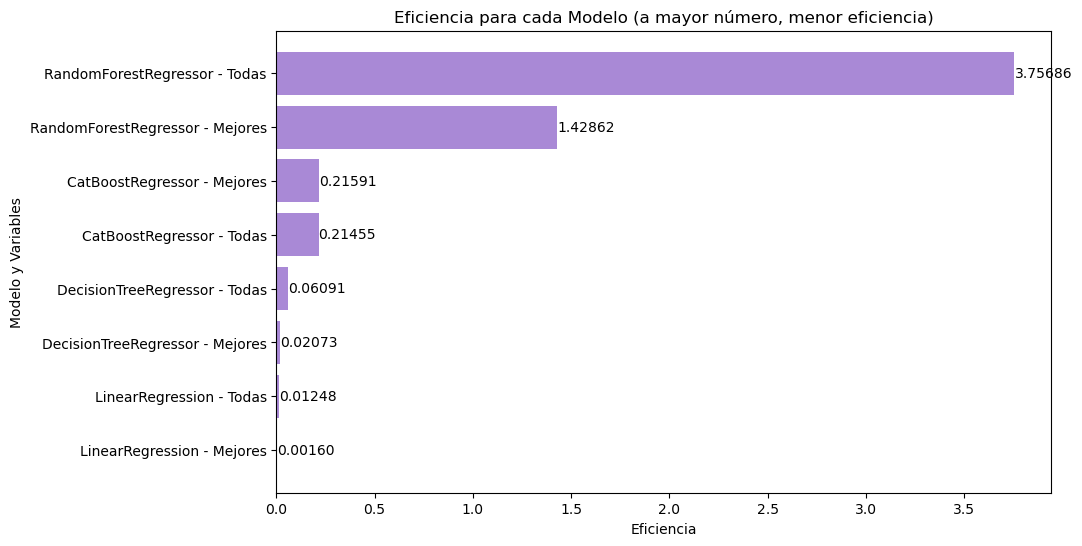

In [102]:
# Ordenar el DataFrame por Rendimiento de menor a mayor
metricas_df_sorted = metricas_df.sort_values(by='Eficiencia')

# Generar nombres para cada dato basados en la suma de las columnas "Modelo" y "Variables"
nombres_datos = metricas_df_sorted['Modelo'] + ' - ' + metricas_df_sorted['Variables']

# Graficar Rendimiento en lugar de R2_test
plt.figure(figsize=(10, 6))
barras = plt.barh(nombres_datos, metricas_df_sorted['Eficiencia'], color='#A989D6')
plt.xlabel('Eficiencia')
plt.ylabel('Modelo y Variables')
plt.title('Eficiencia para cada Modelo (a mayor número, menor eficiencia)')

# Agregar los valores de Rendimiento a cada barra con tres decimales adicionales
for barra in barras:
    valor = barra.get_width()
    plt.text(valor, barra.get_y() + barra.get_height() / 2, f'{valor:.5f}', ha='left', va='center')

plt.show()

Aquí podemos ver como el modelo de regresión lineal ejecutado con las mejores variables triunfa ampliamente por sobre el resto, necesitando solo 0,002 segundos para ganar un punto porcentual de R2, mientras que el menos eficiente es el Random Forest, al cual le toma 3,79 segundo obtener cada punto porcentual de R2. Si bien debemos considerar otros factores esta métrica nos da otra variable para calificar y elegir entre modelos, si consideramos que Random Forest y Cat Boost tienen R2 muy similares, ganando por poco CatBoost, la eficiencia nos ayuda a decantarnos aún más por este último ya que mientras que el Random Forest necesita 3,79 segundos para ganar un punto porcentual de R2, a CatBoost le toma solo 0,21 segundos para obtener el mismo valor porcentual. Es decir, a pesar de que ambos modelos obtienen valores similares de R2 en el conjunto de prueba, CatBoost lo hace aproximadamente 18 veces más rápido que Random Forest. Otro punto para Cat Boost.

#### **Graficando la pérdida de R2**

Ahora veremos como se comportaron los modelos al pasar al conjunto de prueba, el valor mostrado es el resultado de restar el R2 de prueba al R2 de entrenamiento, por lo tanto a medida de que el número aumenta el poder de predicción disminuye. Un número alto de pérdida no solo significará una disminución del poder de predicción, sino también un posible problema del modelo para generalizar en un conjunto de datos nuevos.

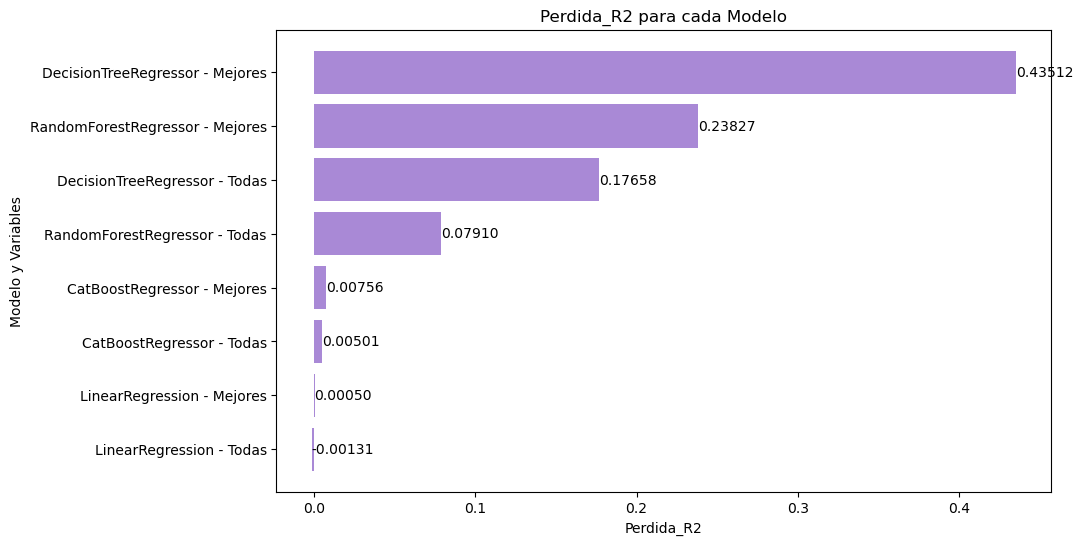

In [103]:
# Ordenar el DataFrame por Pérdida de R2 de menor a mayor
metricas_df_sorted = metricas_df.sort_values(by='Perdida_R2')

# Generar nombres para cada dato basados en la suma de las columnas "Modelo" y "Variables"
nombres_datos = metricas_df_sorted['Modelo'] + ' - ' + metricas_df_sorted['Variables']

# Graficar pérdida de R2
plt.figure(figsize=(10, 6))
barras = plt.barh(nombres_datos, metricas_df_sorted['Perdida_R2'], color='#A989D6')
plt.xlabel('Perdida_R2')
plt.ylabel('Modelo y Variables')
plt.title('Perdida_R2 para cada Modelo')

# Agregar los valores de Rendimiento a cada barra con tres decimales adicionales
for barra in barras:
    valor = barra.get_width()
    plt.text(valor, barra.get_y() + barra.get_height() / 2, f'{valor:.5f}', ha='left', va='center')

plt.show()

En este gráfico podemos observar que la mayor pérdida de R2 al pasar del conjunto de entrenamiento al de pruebas lo sufre el DecisionTreeRegressor utilizando las mejores variables, perdiendo más del 43% de R2. En el lado opuesto tenemos a la regresión lineal con todas las variables, la cual no solo no perdió valor de R2 si no que ganó 0,0013 puntos. Volviendo a la elección si comparamos nuevamente a nuestros mejores modelos: Random Forest y Cat Boost, encontramos nuevamente que CatBoost toma la delantera perdiendo solo 0.005 puntos mientras que Random Forest pierde 0.079. Tercer punto para Cat Boost.

### **Graficando errores**

Graficaremos ahora la pérdida de los distintos tipos de erroes. (Al tratarse de la diferencia entre MAE de entrenamiento y de test, un número negativo significaría un aumento del error, lo que es un poco contraintuitivo, por lo que al graficar, los valores serán invertidos).

#### **Diferencia MAE**

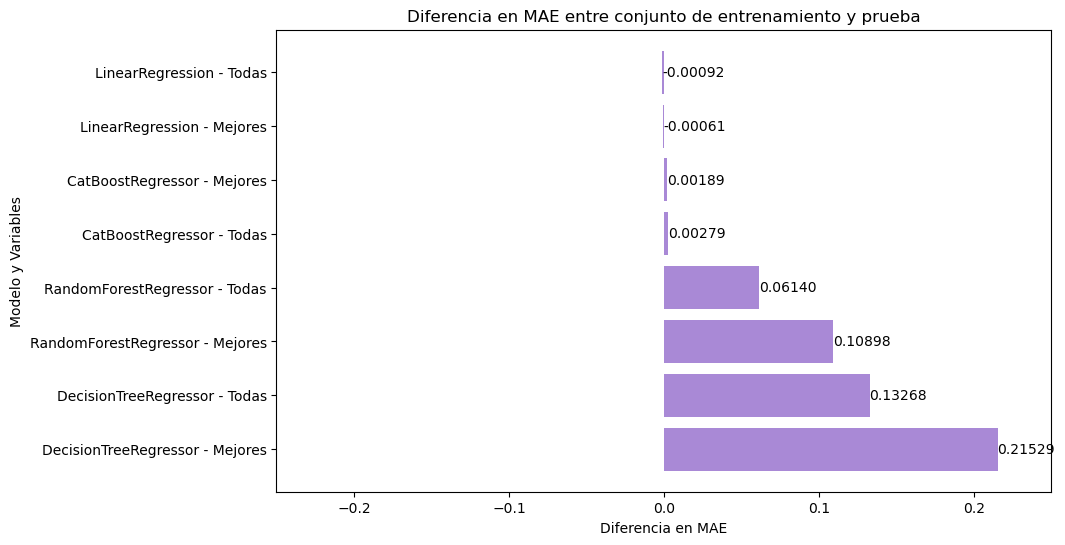

In [104]:
# Ordenar el DataFrame por diferencia en MAE de menor a mayor
metricas_df_sorted = metricas_df.sort_values(by='Diferencia_MAE')

# Generar nombres para cada dato basados en la suma de las columnas "Modelo" y "Variables"
nombres_datos = metricas_df_sorted['Modelo'] + ' - ' + metricas_df_sorted['Variables']

# Cambiar el signo de los valores de Diferencia_MAE
metricas_df_sorted['Diferencia_MAE'] = metricas_df_sorted['Diferencia_MAE'] * -1

# Graficar Diferencia_MAE
plt.figure(figsize=(10, 6))
barras = plt.barh(nombres_datos, metricas_df_sorted['Diferencia_MAE'], color='#A989D6')
plt.xlabel('Diferencia en MAE')
plt.ylabel('Modelo y Variables')
plt.title('Diferencia en MAE entre conjunto de entrenamiento y prueba')

# Establecer límites del eje x
plt.xlim(-0.25, 0.25)

# Agregar los valores de Diferencia_MAE a cada barra
for barra in barras:
    valor = barra.get_width()
    plt.text(valor, barra.get_y() + barra.get_height() / 2, f'{valor:.5f}', ha='left', va='center')

plt.show()

Al observar la diferencia en el MAE entre el conjunto de entrenamiento y prueba, podemos observar que el único que disminuyó el error fue el modelo de regresión lineal, mientras que todos los demás aumentaron este error, cabe destacar que en segundo lugar se encuentra el Cat Boost quien a pesar de aumentar en el error este aumentó en una mínima cantidad, lo que nos puede indicar un poder de generalización correcto para conjunto de datos nuevos.

#### **Diferencia MSE**

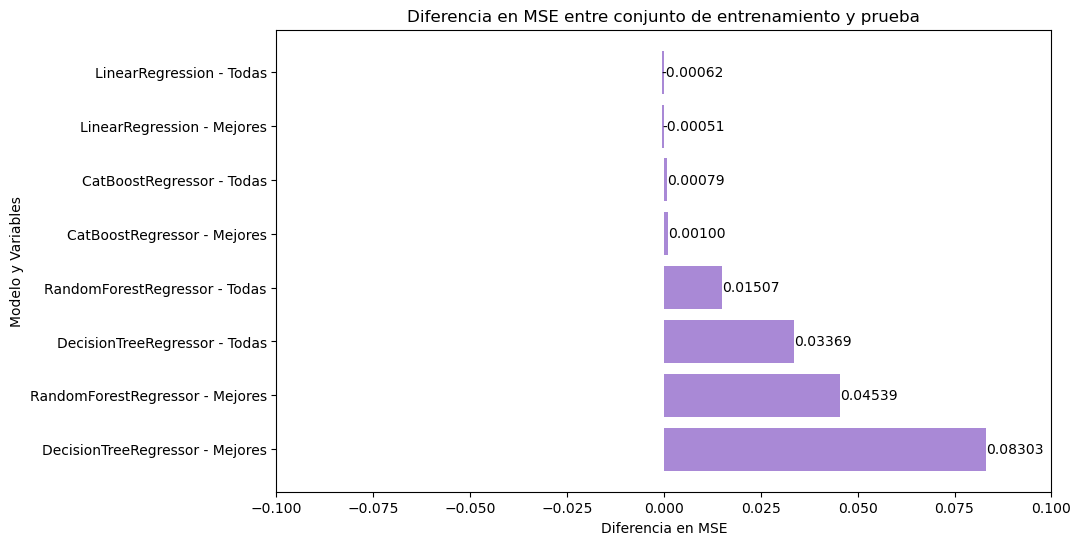

In [105]:
# Ordenar el DataFrame por diferencia en MSE de menor a mayor
metricas_df_sorted = metricas_df.sort_values(by='Diferencia_MSE')

# Generar nombres para cada dato basados en la suma de las columnas "Modelo" y "Variables"
nombres_datos = metricas_df_sorted['Modelo'] + ' - ' + metricas_df_sorted['Variables']

# Cambiar el signo de los valores de Diferencia_MSE
metricas_df_sorted['Diferencia_MSE'] = metricas_df_sorted['Diferencia_MSE'] * -1

# Graficar Diferencia_MSE
plt.figure(figsize=(10, 6))
barras = plt.barh(nombres_datos, metricas_df_sorted['Diferencia_MSE'], color='#A989D6')
plt.xlabel('Diferencia en MSE')
plt.ylabel('Modelo y Variables')
plt.title('Diferencia en MSE entre conjunto de entrenamiento y prueba')

# Establecer límites del eje x
# Ajustar según sea necesario
plt.xlim(-0.1, 0.1)

# Agregar los valores de Diferencia_MSE a cada barra
for barra in barras:
    valor = barra.get_width()
    plt.text(valor, barra.get_y() + barra.get_height() / 2, f'{valor:.5f}', ha='left', va='center')

plt.show()

Observamos lo mismo que en el gráfico anterior. La regresión lineal mejora al pasar al conjunto de prueba y Cat Boost apenas aumenta.

#### **Diferencia MedAE**

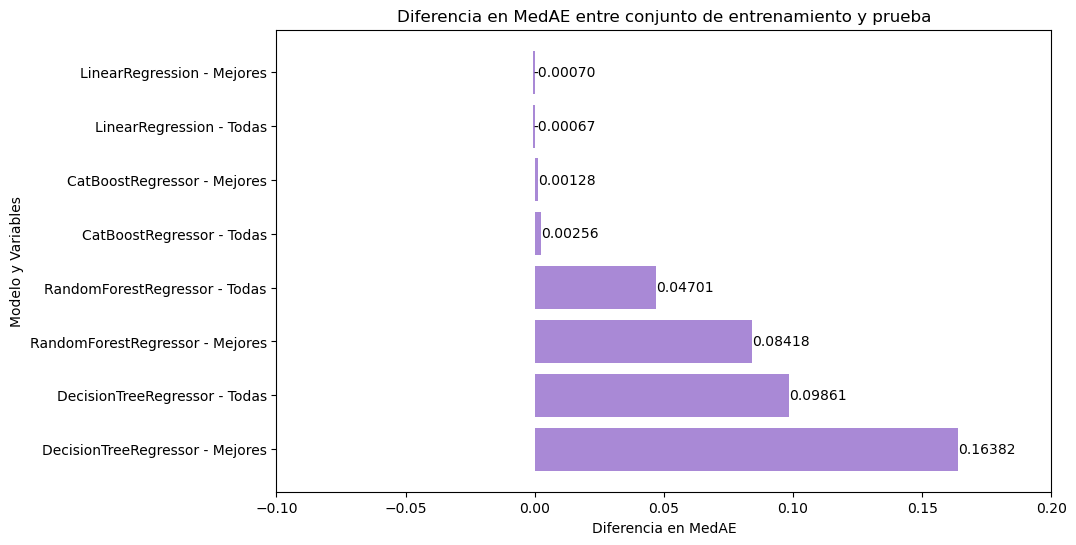

In [106]:
# Ordenar el DataFrame por diferencia en MedAE de menor a mayor
metricas_df_sorted = metricas_df.sort_values(by='Diferencia_MedAE')

# Generar nombres para cada dato basados en la suma de las columnas "Modelo" y "Variables"
nombres_datos = metricas_df_sorted['Modelo'] + ' - ' + metricas_df_sorted['Variables']

# Cambiar el signo de los valores de Diferencia_MedAe
metricas_df_sorted['Diferencia_MedAE'] = metricas_df_sorted['Diferencia_MedAE'] * -1

# Graficar Diferencia_MedAe
plt.figure(figsize=(10, 6))
barras = plt.barh(nombres_datos, metricas_df_sorted['Diferencia_MedAE'], color='#A989D6')
plt.xlabel('Diferencia en MedAE')
plt.ylabel('Modelo y Variables')
plt.title('Diferencia en MedAE entre conjunto de entrenamiento y prueba')

# Establecer límites del eje x
# Ajustar según sea necesario
plt.xlim(-0.1, 0.2)

# Agregar los valores de Diferencia_MedAe a cada barra
for barra in barras:
    valor = barra.get_width()
    plt.text(valor, barra.get_y() + barra.get_height() / 2, f'{valor:.5f}', ha='left', va='center')

plt.show()

La historia se repite en este error. Regresión lineal mejora. Cat Boost aumenta su error en una cantidad mínima.

Entre estos modelos, el RandomForestRegressor y el CatBoostRegressor parecen tener un rendimiento general similar y mejor que el DecisionTreeRegressor en términos de generalización y precisión de las predicciones en el conjunto de prueba. Sin embargo, el RandomForestRegressor tiene un tiempo de entrenamiento mucho más largo en comparación con el CatBoostRegressor.

Por lo tanto, si priorizamos la precisión y la generalización del modelo sobre el tiempo de entrenamiento, el **CatBoostRegressor podría considerarse el mejor modelo**. 

CatBoostRegressor, desarrollada por Yandex, es una potente biblioteca de gradient boosting. El gradient boosting es una técnica ampliamente utilizada en el aprendizaje automático, especialmente en problemas de regresión, debido a su capacidad para construir modelos altamente precisos y robustos. Además, ofrece regularización integrada para evitar el sobreajuste, garantizando así un rendimiento sólido y una buena generalización incluso en conjuntos de datos de baja calidad.

### **Cat Boost Regressor: Con ajuste de hiperparámetros**

Luego de ver como se desempeñaron los modelos y haber elegido al Catboostregressor como el mejor de los cuatro, intentaremos mejorar los resultados obtenidos con este modelo a través de la modificación de parámetros, para ello utilizaremos RandomizedSearchCV y no GridSearchCV, ya que al iterar tantas veces GridSearchCV tiende a quedarse sin memoria.

In [107]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'iterations': randint(10, 1000),  # Número de iteraciones del algoritmo de boosting
    'learning_rate': uniform(0.01, 0.5),  # Tasa de aprendizaje
    'depth': randint(1, 10),  # Profundidad máxima del árbol
    'l2_leaf_reg': uniform(0, 10),  # Regularización L2
    'border_count': randint(1, 255),  # Número de divisiones para los atributos categóricos
}

# Inicializar el modelo CatBoostRegressor
cb = CatBoostRegressor()

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=cb, param_distributions=param_grid, n_iter=100,
                                   scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)

# Ajustar RandomizedSearchCV al conjunto de datos de entrenamiento
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Mostrar el error cuadrático medio negativo promedio de las validaciones cruzadas para los mejores hiperparámetros
print("Error cuadrático medio negativo promedio de las validaciones cruzadas para los mejores hiperparámetros:")
print(random_search.best_score_)

# Obtener el mejor modelo entrenado
best_model = random_search.best_estimator_

# Realizar predicciones con el mejor modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluar el rendimiento del mejor modelo en el conjunto de prueba
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir métricas de evaluación del mejor modelo en el conjunto de prueba
print("\nMétricas de evaluación del mejor modelo en el conjunto de prueba:")
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Median Absolute Error: {medae}')
print(f'R-squared: {r2}')

0:	learn: 0.3772489	total: 5.33ms	remaining: 5.07s
1:	learn: 0.3308665	total: 10.8ms	remaining: 5.12s
2:	learn: 0.2960469	total: 16.2ms	remaining: 5.12s
3:	learn: 0.2696335	total: 21.2ms	remaining: 5.04s
4:	learn: 0.2496792	total: 26.5ms	remaining: 5.03s
5:	learn: 0.2343870	total: 31.6ms	remaining: 4.99s
6:	learn: 0.2232077	total: 37ms	remaining: 4.99s
7:	learn: 0.2143548	total: 42ms	remaining: 4.95s
8:	learn: 0.2077343	total: 47.1ms	remaining: 4.93s
9:	learn: 0.2017596	total: 52.9ms	remaining: 4.98s
10:	learn: 0.1964338	total: 57.9ms	remaining: 4.95s
11:	learn: 0.1922218	total: 63.1ms	remaining: 4.94s
12:	learn: 0.1885341	total: 68.2ms	remaining: 4.92s
13:	learn: 0.1855362	total: 73.4ms	remaining: 4.92s
14:	learn: 0.1828712	total: 78.6ms	remaining: 4.91s
15:	learn: 0.1804160	total: 83.8ms	remaining: 4.9s
16:	learn: 0.1783783	total: 89.5ms	remaining: 4.92s
17:	learn: 0.1761263	total: 94.7ms	remaining: 4.91s
18:	learn: 0.1738636	total: 99.6ms	remaining: 4.89s
19:	learn: 0.1722733	total:

Aplicamos las variables obtenidas en un nuevo modelo CatBoostRegressor.

In [108]:
# Medir el tiempo de inicio
start_time = time.time()

# Definir las variables
# Definir las variables independientes (X) y la variable objetivo (y)
X = xTodas_Variables
y = df['Price_log']

# Dividir el conjunto de datos en entrenamiento y prueba
# Parámetros modificables: test_size, random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo CatBoostRegressor
# Parámetros modificables: verbose
cb = CatBoostRegressor(iterations = 952, learning_rate = 0.2, depth = 8, border_count = 199, l2_leaf_reg = 1.73,  verbose = False)

# Ajustar el modelo al conjunto de entrenamiento utilizando cross-validation
# Parámetros modificables: cv, scoring
scores = cross_val_score(cb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio negativo promedio de las validaciones cruzadas
mse_cv_mean = np.mean(scores) * -1

# Ajustar el modelo al conjunto de entrenamiento
# Parámetros modificables: verbose
cb.fit(X_train, y_train, verbose=False)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = cb.predict(X_train)

# Evaluar el rendimiento del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
medae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = cb.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
medae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Medir el tiempo de finalización
training_time = time.time() - start_time

# Agregar las métricas al DataFrame
metricas_df.loc[len(metricas_df)] = {
    'Modelo': 'CatBoostRegressorTuned',
    'Variables': 'Mejores' if np.array_equal(X, xMejores_variables) else 'Todas',
    'MAE_train': mae_train,
    'MSE_train': mse_train,
    'MedAE_train': medae_train,
    'R2_train': r2_train,
    'MAE_test': mae_test,
    'MSE_test': mse_test,
    'MedAE_test': medae_test,
    'R2_test': r2_test,
    'MSE_CV_mean': mse_cv_mean,
    'Tiempo_entrenamiento': training_time
}

# Imprimir las métricas de evaluación para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print(f'Mean Absolute Error: {mae_train}')
print(f'Mean Squared Error: {mse_train}')
print(f'Median Absolute Error: {medae_train}')
print(f'R-squared: {r2_train}')

# Imprimir las métricas de evaluación para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Squared Error: {mse_test}')
print(f'Median Absolute Error: {medae_test}')
print(f'R-squared: {r2_test}')

# Imprimir el error cuadrático medio negativo promedio de las validaciones cruzadas
print("\nError cuadrático medio negativo promedio de las validaciones cruzadas:")
print(f'Mean Squared Error (CV): {mse_cv_mean}')

# Imprimir el tiempo de ejecución
print("\nTiempo de ejecución:", training_time, "segundos")

Métricas para el conjunto de entrenamiento:
Mean Absolute Error: 0.07708079176091553
Mean Squared Error: 0.01048051274822667
Median Absolute Error: 0.06047638588415616
R-squared: 0.9456751185270978

Métricas para el conjunto de prueba:
Mean Absolute Error: 0.08992905933383577
Mean Squared Error: 0.014597469947593809
Median Absolute Error: 0.07037881261434364
R-squared: 0.9235006370617462

Error cuadrático medio negativo promedio de las validaciones cruzadas:
Mean Squared Error (CV): 0.015378243176672555

Tiempo de ejecución: 28.4670193195343 segundos


El modelo CatBoostRegressor, luego de ajustar sus parámetros, exhibe un desempeño notablemente sólido. En el conjunto de entrenamiento, el modelo muestra un bajo **Mean Absolute Error (MAE) de 0.077** y un alto coeficiente de determinación **(R²) de 0.945**, indicando una **buena capacidad para explicar la variabilidad de la variable dependiente**. Estas métricas se mantienen consistentemente altas en el conjunto de prueba, con un **MAE de 0.089 y un R² de 0.923**, lo que sugiere una **capacidad de generalización satisfactoria**. El tiempo de ejecución de aproximadamente 28 segundos es razonable dada la complejidad del modelo y el tamaño de los datos. En resumen, el **CatBoostRegressor muestra un rendimiento sólido y una buena generalización en datos no vistos luego de modificar sus parámetros**.

Si bien, trabajando un poco más nuestras variables y mejorando los parámetros del modelo, este podría aumentar su desempeño, el modelo muestra una capacidad de predicción y generalización sólida, siendo bastante eficiente en el uso del tiempo, por lo que, por ahora, damos por terminado este paso.

# **The end.**